In [5]:
# For RNA secondary structure predictions using ViennaRNA
!apt-get install -y vienna-rna
!pip install viennarna

# For PyTorch Geometric (GNN support)
# Step-by-step installation compatible with current Colab environment
import torch
TORCH = torch.__version__.split('+')[0]

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}.html
!pip install torch-geometric

# Optional visualization tools
!pip install seaborn matplotlib scikit-learn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
vienna-rna is already the newest version (2.4.17+dfsg-2build2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 99.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622721 sha256=65e1e8b447db38814978510462af1d36ec0d49e4d6b8ad945c77f8461f2f2b09
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.6.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created whee

In [6]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, confusion_matrix
import networkx as nx
import subprocess
import RNA
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("dataset_1.csv")

# Encode nucleotides to integers
nuc_to_idx = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def encode_seq(seq, max_len=50):
    encoded = [nuc_to_idx.get(nuc, 0) for nuc in seq.upper()]
    return encoded + [0] * (max_len - len(encoded)) if len(encoded) < max_len else encoded[:max_len]

# Apply encoding
df['miRNA_enc'] = df['miRNA_isomiR'].apply(encode_seq)
df['mRNA_enc'] = df['mRNA'].apply(encode_seq)

# Stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [10]:
# Dataset class
class InteractionDataset(Dataset):
    def __init__(self, df):
        self.mirnas = df['miRNA_enc'].tolist()
        self.mrnas = df['mRNA_enc'].tolist()
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mirna = torch.tensor(self.mirnas[idx], dtype=torch.long)
        mrna = torch.tensor(self.mrnas[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return mirna, mrna, label

# Data loaders
train_data = InteractionDataset(train_df)
test_data = InteractionDataset(test_df)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
# Transformer model
class InteractionTransformer(nn.Module):
    def __init__(self, embedding_dim=32, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=5, embedding_dim=embedding_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, mirna, mrna):
        mirna_embed = self.embedding(mirna).permute(1, 0, 2)
        mrna_embed = self.embedding(mrna).permute(1, 0, 2)
        mirna_encoded = self.transformer(mirna_embed).mean(dim=0)
        mrna_encoded = self.transformer(mrna_embed).mean(dim=0)
        combined = torch.cat((mirna_encoded, mrna_encoded), dim=1)
        return self.fc(combined).squeeze()

In [12]:
# Initialize model, loss, optimizer
model = InteractionTransformer().to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
# Training loop with debug statements
losses = []
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_idx, (mirna, mrna, labels) in enumerate(tqdm(train_loader)):
        mirna, mrna, labels = mirna.to(device), mrna.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(mirna, mrna)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.6f}")

  0%|          | 9/10657 [00:01<20:18,  8.74it/s]  

Epoch 1, Batch 0, Loss: 0.689567


  1%|          | 116/10657 [00:02<02:12, 79.85it/s]

Epoch 1, Batch 100, Loss: 0.631349


  2%|▏         | 215/10657 [00:03<02:04, 84.09it/s]

Epoch 1, Batch 200, Loss: 0.679410


  3%|▎         | 314/10657 [00:05<02:04, 82.81it/s]

Epoch 1, Batch 300, Loss: 0.636349


  4%|▍         | 413/10657 [00:06<02:02, 83.67it/s]

Epoch 1, Batch 400, Loss: 0.621616


  5%|▍         | 512/10657 [00:07<01:59, 85.10it/s]

Epoch 1, Batch 500, Loss: 0.645595


  6%|▌         | 607/10657 [00:08<02:45, 60.80it/s]

Epoch 1, Batch 600, Loss: 0.625283


  7%|▋         | 711/10657 [00:10<02:00, 82.72it/s]

Epoch 1, Batch 700, Loss: 0.551356


  8%|▊         | 810/10657 [00:11<01:55, 84.95it/s]

Epoch 1, Batch 800, Loss: 0.638921


  9%|▊         | 909/10657 [00:12<02:01, 80.40it/s]

Epoch 1, Batch 900, Loss: 0.654297


 10%|▉         | 1017/10657 [00:14<01:59, 81.00it/s]

Epoch 1, Batch 1000, Loss: 0.537013


 10%|█         | 1116/10657 [00:15<01:53, 83.70it/s]

Epoch 1, Batch 1100, Loss: 0.636133


 11%|█▏        | 1215/10657 [00:16<01:52, 84.21it/s]

Epoch 1, Batch 1200, Loss: 0.608901


 12%|█▏        | 1314/10657 [00:17<01:52, 83.09it/s]

Epoch 1, Batch 1300, Loss: 0.705556


 13%|█▎        | 1413/10657 [00:18<01:50, 83.40it/s]

Epoch 1, Batch 1400, Loss: 0.585806


 14%|█▍        | 1512/10657 [00:20<02:22, 63.95it/s]

Epoch 1, Batch 1500, Loss: 0.626331


 15%|█▌        | 1611/10657 [00:21<02:02, 73.96it/s]

Epoch 1, Batch 1600, Loss: 0.601392


 16%|█▌        | 1709/10657 [00:23<01:47, 83.46it/s]

Epoch 1, Batch 1700, Loss: 0.636149


 17%|█▋        | 1817/10657 [00:24<01:48, 81.69it/s]

Epoch 1, Batch 1800, Loss: 0.661918


 18%|█▊        | 1916/10657 [00:25<01:45, 83.07it/s]

Epoch 1, Batch 1900, Loss: 0.618920


 19%|█▉        | 2015/10657 [00:26<01:42, 84.14it/s]

Epoch 1, Batch 2000, Loss: 0.637613


 20%|█▉        | 2114/10657 [00:27<01:41, 84.23it/s]

Epoch 1, Batch 2100, Loss: 0.598863


 21%|██        | 2213/10657 [00:29<01:40, 83.85it/s]

Epoch 1, Batch 2200, Loss: 0.649209


 22%|██▏       | 2312/10657 [00:30<01:39, 83.93it/s]

Epoch 1, Batch 2300, Loss: 0.608538


 23%|██▎       | 2411/10657 [00:31<01:40, 81.95it/s]

Epoch 1, Batch 2400, Loss: 0.627328


 24%|██▎       | 2512/10657 [00:33<02:19, 58.28it/s]

Epoch 1, Batch 2500, Loss: 0.658822


 24%|██▍       | 2610/10657 [00:34<01:34, 85.00it/s]

Epoch 1, Batch 2600, Loss: 0.702229


 26%|██▌       | 2718/10657 [00:35<01:34, 83.87it/s]

Epoch 1, Batch 2700, Loss: 0.620773


 26%|██▋       | 2817/10657 [00:36<01:35, 82.46it/s]

Epoch 1, Batch 2800, Loss: 0.642156


 27%|██▋       | 2916/10657 [00:38<01:31, 84.28it/s]

Epoch 1, Batch 2900, Loss: 0.581408


 28%|██▊       | 3015/10657 [00:39<01:30, 84.64it/s]

Epoch 1, Batch 3000, Loss: 0.603877


 29%|██▉       | 3114/10657 [00:40<01:29, 84.71it/s]

Epoch 1, Batch 3100, Loss: 0.610913


 30%|███       | 3207/10657 [00:42<02:54, 42.78it/s]

Epoch 1, Batch 3200, Loss: 0.614116


 31%|███       | 3304/10657 [00:45<03:48, 32.22it/s]

Epoch 1, Batch 3300, Loss: 0.671920


 32%|███▏      | 3409/10657 [00:48<02:36, 46.45it/s]

Epoch 1, Batch 3400, Loss: 0.627434


 33%|███▎      | 3505/10657 [00:50<02:45, 43.12it/s]

Epoch 1, Batch 3500, Loss: 0.544129


 34%|███▍      | 3613/10657 [00:52<01:27, 80.65it/s]

Epoch 1, Batch 3600, Loss: 0.644342


 35%|███▍      | 3712/10657 [00:53<01:23, 83.12it/s]

Epoch 1, Batch 3700, Loss: 0.619801


 36%|███▌      | 3811/10657 [00:54<01:22, 82.50it/s]

Epoch 1, Batch 3800, Loss: 0.577964


 37%|███▋      | 3910/10657 [00:55<01:20, 84.04it/s]

Epoch 1, Batch 3900, Loss: 0.677135


 38%|███▊      | 4014/10657 [00:57<01:41, 65.20it/s]

Epoch 1, Batch 4000, Loss: 0.586149


 39%|███▊      | 4116/10657 [00:58<01:24, 77.65it/s]

Epoch 1, Batch 4100, Loss: 0.612169


 40%|███▉      | 4215/10657 [01:00<01:16, 84.75it/s]

Epoch 1, Batch 4200, Loss: 0.613942


 40%|████      | 4314/10657 [01:01<01:15, 83.90it/s]

Epoch 1, Batch 4300, Loss: 0.569876


 41%|████▏     | 4413/10657 [01:02<01:13, 84.45it/s]

Epoch 1, Batch 4400, Loss: 0.609440


 42%|████▏     | 4512/10657 [01:03<01:12, 84.75it/s]

Epoch 1, Batch 4500, Loss: 0.513869


 43%|████▎     | 4611/10657 [01:04<01:14, 80.73it/s]

Epoch 1, Batch 4600, Loss: 0.604331


 44%|████▍     | 4710/10657 [01:06<01:12, 82.30it/s]

Epoch 1, Batch 4700, Loss: 0.640206


 45%|████▌     | 4818/10657 [01:07<01:09, 83.91it/s]

Epoch 1, Batch 4800, Loss: 0.580431


 46%|████▌     | 4908/10657 [01:08<01:14, 77.31it/s]

Epoch 1, Batch 4900, Loss: 0.596671


 47%|████▋     | 5007/10657 [01:10<01:37, 57.73it/s]

Epoch 1, Batch 5000, Loss: 0.661081


 48%|████▊     | 5115/10657 [01:11<01:07, 82.39it/s]

Epoch 1, Batch 5100, Loss: 0.583894


 49%|████▉     | 5214/10657 [01:12<01:04, 84.26it/s]

Epoch 1, Batch 5200, Loss: 0.686241


 50%|████▉     | 5313/10657 [01:13<01:03, 83.94it/s]

Epoch 1, Batch 5300, Loss: 0.585046


 51%|█████     | 5412/10657 [01:15<01:02, 83.66it/s]

Epoch 1, Batch 5400, Loss: 0.598096


 52%|█████▏    | 5511/10657 [01:16<01:02, 82.65it/s]

Epoch 1, Batch 5500, Loss: 0.624956


 53%|█████▎    | 5610/10657 [01:17<01:04, 78.49it/s]

Epoch 1, Batch 5600, Loss: 0.716684


 54%|█████▎    | 5717/10657 [01:18<00:59, 83.06it/s]

Epoch 1, Batch 5700, Loss: 0.611182


 55%|█████▍    | 5816/10657 [01:19<00:57, 84.45it/s]

Epoch 1, Batch 5800, Loss: 0.618871


 55%|█████▌    | 5910/10657 [01:21<01:16, 62.34it/s]

Epoch 1, Batch 5900, Loss: 0.632836


 56%|█████▋    | 6013/10657 [01:22<00:59, 78.50it/s]

Epoch 1, Batch 6000, Loss: 0.635715


 57%|█████▋    | 6112/10657 [01:24<00:53, 85.13it/s]

Epoch 1, Batch 6100, Loss: 0.596777


 58%|█████▊    | 6211/10657 [01:25<00:52, 84.95it/s]

Epoch 1, Batch 6200, Loss: 0.700089


 59%|█████▉    | 6310/10657 [01:26<00:51, 84.19it/s]

Epoch 1, Batch 6300, Loss: 0.593500


 60%|██████    | 6409/10657 [01:27<00:51, 82.34it/s]

Epoch 1, Batch 6400, Loss: 0.651590


 61%|██████    | 6517/10657 [01:28<00:50, 82.46it/s]

Epoch 1, Batch 6500, Loss: 0.689890


 62%|██████▏   | 6615/10657 [01:30<00:49, 80.97it/s]

Epoch 1, Batch 6600, Loss: 0.666109


 63%|██████▎   | 6714/10657 [01:31<00:46, 84.50it/s]

Epoch 1, Batch 6700, Loss: 0.720689


 64%|██████▍   | 6813/10657 [01:32<00:52, 72.84it/s]

Epoch 1, Batch 6800, Loss: 0.664867


 65%|██████▍   | 6912/10657 [01:34<01:05, 57.55it/s]

Epoch 1, Batch 6900, Loss: 0.563382


 66%|██████▌   | 7013/10657 [01:35<00:43, 83.30it/s]

Epoch 1, Batch 7000, Loss: 0.650893


 67%|██████▋   | 7112/10657 [01:36<00:42, 83.41it/s]

Epoch 1, Batch 7100, Loss: 0.659639


 68%|██████▊   | 7211/10657 [01:37<00:40, 85.86it/s]

Epoch 1, Batch 7200, Loss: 0.751150


 69%|██████▊   | 7310/10657 [01:39<00:40, 82.08it/s]

Epoch 1, Batch 7300, Loss: 0.675189


 70%|██████▉   | 7418/10657 [01:40<00:38, 83.91it/s]

Epoch 1, Batch 7400, Loss: 0.537043


 71%|███████   | 7517/10657 [01:41<00:37, 84.19it/s]

Epoch 1, Batch 7500, Loss: 0.598985


 71%|███████▏  | 7616/10657 [01:42<00:36, 84.11it/s]

Epoch 1, Batch 7600, Loss: 0.670122


 72%|███████▏  | 7715/10657 [01:43<00:35, 83.57it/s]

Epoch 1, Batch 7700, Loss: 0.631300


 73%|███████▎  | 7811/10657 [01:45<00:47, 60.46it/s]

Epoch 1, Batch 7800, Loss: 0.618744


 74%|███████▍  | 7914/10657 [01:46<00:35, 78.29it/s]

Epoch 1, Batch 7900, Loss: 0.597940


 75%|███████▌  | 8012/10657 [01:48<00:31, 82.97it/s]

Epoch 1, Batch 8000, Loss: 0.565601


 76%|███████▌  | 8111/10657 [01:49<00:31, 80.80it/s]

Epoch 1, Batch 8100, Loss: 0.613935


 77%|███████▋  | 8210/10657 [01:50<00:29, 81.93it/s]

Epoch 1, Batch 8200, Loss: 0.632875


 78%|███████▊  | 8318/10657 [01:51<00:28, 83.32it/s]

Epoch 1, Batch 8300, Loss: 0.662582


 79%|███████▉  | 8417/10657 [01:53<00:26, 85.46it/s]

Epoch 1, Batch 8400, Loss: 0.630911


 80%|███████▉  | 8516/10657 [01:54<00:25, 85.05it/s]

Epoch 1, Batch 8500, Loss: 0.703476


 81%|████████  | 8611/10657 [01:55<00:26, 78.43it/s]

Epoch 1, Batch 8600, Loss: 0.680031


 82%|████████▏ | 8705/10657 [01:56<00:30, 64.92it/s]

Epoch 1, Batch 8700, Loss: 0.575133


 83%|████████▎ | 8811/10657 [01:58<00:33, 54.66it/s]

Epoch 1, Batch 8800, Loss: 0.590688


 84%|████████▎ | 8909/10657 [01:59<00:22, 79.13it/s]

Epoch 1, Batch 8900, Loss: 0.613746


 85%|████████▍ | 9017/10657 [02:01<00:19, 83.89it/s]

Epoch 1, Batch 9000, Loss: 0.548198


 86%|████████▌ | 9112/10657 [02:02<00:20, 76.56it/s]

Epoch 1, Batch 9100, Loss: 0.524089


 86%|████████▋ | 9211/10657 [02:03<00:18, 79.44it/s]

Epoch 1, Batch 9200, Loss: 0.551467


 87%|████████▋ | 9311/10657 [02:04<00:17, 78.90it/s]

Epoch 1, Batch 9300, Loss: 0.590329


 88%|████████▊ | 9415/10657 [02:06<00:16, 73.23it/s]

Epoch 1, Batch 9400, Loss: 0.615819


 89%|████████▉ | 9511/10657 [02:07<00:15, 73.34it/s]

Epoch 1, Batch 9500, Loss: 0.665339


 90%|█████████ | 9610/10657 [02:09<00:19, 53.65it/s]

Epoch 1, Batch 9600, Loss: 0.641978


 91%|█████████ | 9715/10657 [02:11<00:15, 60.67it/s]

Epoch 1, Batch 9700, Loss: 0.602794


 92%|█████████▏| 9812/10657 [02:12<00:11, 73.20it/s]

Epoch 1, Batch 9800, Loss: 0.589693


 93%|█████████▎| 9916/10657 [02:13<00:09, 74.69it/s]

Epoch 1, Batch 9900, Loss: 0.577998


 94%|█████████▍| 10014/10657 [02:15<00:08, 74.17it/s]

Epoch 1, Batch 10000, Loss: 0.639374


 95%|█████████▍| 10112/10657 [02:16<00:07, 73.50it/s]

Epoch 1, Batch 10100, Loss: 0.533098


 96%|█████████▌| 10216/10657 [02:17<00:06, 72.37it/s]

Epoch 1, Batch 10200, Loss: 0.618273


 97%|█████████▋| 10315/10657 [02:19<00:04, 77.56it/s]

Epoch 1, Batch 10300, Loss: 0.572228


 98%|█████████▊| 10415/10657 [02:20<00:03, 79.46it/s]

Epoch 1, Batch 10400, Loss: 0.684818


 99%|█████████▊| 10498/10657 [02:21<00:02, 53.80it/s]

Epoch 1, Batch 10500, Loss: 0.636589


100%|█████████▉| 10610/10657 [02:24<00:00, 77.34it/s]

Epoch 1, Batch 10600, Loss: 0.578257


100%|██████████| 10657/10657 [02:24<00:00, 73.59it/s]


Epoch 1 completed. Average Loss: 0.622870


  0%|          | 5/10657 [00:00<03:34, 49.57it/s]

Epoch 2, Batch 0, Loss: 0.588020


  1%|          | 110/10657 [00:01<02:15, 77.98it/s]

Epoch 2, Batch 100, Loss: 0.586294


  2%|▏         | 212/10657 [00:02<02:12, 79.13it/s]

Epoch 2, Batch 200, Loss: 0.599231


  3%|▎         | 309/10657 [00:03<02:14, 77.03it/s]

Epoch 2, Batch 300, Loss: 0.599306


  4%|▍         | 414/10657 [00:05<02:12, 77.35it/s]

Epoch 2, Batch 400, Loss: 0.641346


  5%|▍         | 511/10657 [00:06<02:01, 83.31it/s]

Epoch 2, Batch 500, Loss: 0.646614


  6%|▌         | 616/10657 [00:07<02:06, 79.65it/s]

Epoch 2, Batch 600, Loss: 0.631116


  7%|▋         | 709/10657 [00:09<02:49, 58.83it/s]

Epoch 2, Batch 700, Loss: 0.564054


  8%|▊         | 810/10657 [00:10<02:11, 75.05it/s]

Epoch 2, Batch 800, Loss: 0.573950


  9%|▊         | 917/10657 [00:12<01:57, 82.88it/s]

Epoch 2, Batch 900, Loss: 0.710170


 10%|▉         | 1016/10657 [00:13<01:53, 85.11it/s]

Epoch 2, Batch 1000, Loss: 0.642758


 10%|█         | 1115/10657 [00:14<01:56, 81.68it/s]

Epoch 2, Batch 1100, Loss: 0.634498


 11%|█▏        | 1214/10657 [00:15<01:53, 83.11it/s]

Epoch 2, Batch 1200, Loss: 0.605195


 12%|█▏        | 1313/10657 [00:16<01:54, 81.48it/s]

Epoch 2, Batch 1300, Loss: 0.545023


 13%|█▎        | 1412/10657 [00:18<01:51, 83.12it/s]

Epoch 2, Batch 1400, Loss: 0.652541


 14%|█▍        | 1511/10657 [00:19<01:49, 83.16it/s]

Epoch 2, Batch 1500, Loss: 0.586263


 15%|█▌        | 1610/10657 [00:20<02:01, 74.51it/s]

Epoch 2, Batch 1600, Loss: 0.551818


 16%|█▌        | 1708/10657 [00:22<02:33, 58.31it/s]

Epoch 2, Batch 1700, Loss: 0.601204


 17%|█▋        | 1812/10657 [00:23<01:48, 81.88it/s]

Epoch 2, Batch 1800, Loss: 0.579121


 18%|█▊        | 1911/10657 [00:24<01:49, 80.22it/s]

Epoch 2, Batch 1900, Loss: 0.624348


 19%|█▉        | 2010/10657 [00:26<01:45, 81.78it/s]

Epoch 2, Batch 2000, Loss: 0.611650


 20%|█▉        | 2118/10657 [00:27<01:41, 83.94it/s]

Epoch 2, Batch 2100, Loss: 0.573274


 21%|██        | 2217/10657 [00:28<01:39, 84.50it/s]

Epoch 2, Batch 2200, Loss: 0.622852


 22%|██▏       | 2316/10657 [00:29<01:38, 84.41it/s]

Epoch 2, Batch 2300, Loss: 0.639635


 23%|██▎       | 2415/10657 [00:30<01:38, 83.25it/s]

Epoch 2, Batch 2400, Loss: 0.570454


 24%|██▎       | 2514/10657 [00:32<01:40, 80.98it/s]

Epoch 2, Batch 2500, Loss: 0.622270


 24%|██▍       | 2609/10657 [00:33<02:09, 62.10it/s]

Epoch 2, Batch 2600, Loss: 0.622555


 25%|██▌       | 2712/10657 [00:35<01:41, 78.01it/s]

Epoch 2, Batch 2700, Loss: 0.570132


 26%|██▋       | 2810/10657 [00:36<01:36, 81.41it/s]

Epoch 2, Batch 2800, Loss: 0.578327


 27%|██▋       | 2918/10657 [00:37<01:32, 83.83it/s]

Epoch 2, Batch 2900, Loss: 0.656453


 28%|██▊       | 3017/10657 [00:38<01:32, 82.76it/s]

Epoch 2, Batch 3000, Loss: 0.531868


 29%|██▉       | 3116/10657 [00:40<01:30, 83.37it/s]

Epoch 2, Batch 3100, Loss: 0.597136


 30%|███       | 3215/10657 [00:41<01:28, 83.62it/s]

Epoch 2, Batch 3200, Loss: 0.602803


 31%|███       | 3314/10657 [00:42<01:29, 82.25it/s]

Epoch 2, Batch 3300, Loss: 0.590101


 32%|███▏      | 3413/10657 [00:43<01:26, 83.37it/s]

Epoch 2, Batch 3400, Loss: 0.592464


 33%|███▎      | 3511/10657 [00:44<01:49, 65.49it/s]

Epoch 2, Batch 3500, Loss: 0.573591


 34%|███▍      | 3606/10657 [00:46<02:06, 55.72it/s]

Epoch 2, Batch 3600, Loss: 0.545089


 35%|███▍      | 3718/10657 [00:47<01:25, 81.33it/s]

Epoch 2, Batch 3700, Loss: 0.555989


 36%|███▌      | 3817/10657 [00:49<01:23, 81.81it/s]

Epoch 2, Batch 3800, Loss: 0.595175


 37%|███▋      | 3916/10657 [00:50<01:21, 82.76it/s]

Epoch 2, Batch 3900, Loss: 0.597106


 38%|███▊      | 4015/10657 [00:51<01:19, 83.06it/s]

Epoch 2, Batch 4000, Loss: 0.685484


 39%|███▊      | 4114/10657 [00:52<01:17, 84.58it/s]

Epoch 2, Batch 4100, Loss: 0.584586


 40%|███▉      | 4212/10657 [00:53<01:19, 81.31it/s]

Epoch 2, Batch 4200, Loss: 0.663531


 40%|████      | 4311/10657 [00:55<01:16, 82.46it/s]

Epoch 2, Batch 4300, Loss: 0.564403


 41%|████▏     | 4410/10657 [00:56<01:13, 85.10it/s]

Epoch 2, Batch 4400, Loss: 0.625847


 42%|████▏     | 4511/10657 [00:57<01:37, 62.88it/s]

Epoch 2, Batch 4500, Loss: 0.599449


 43%|████▎     | 4613/10657 [00:59<01:16, 79.05it/s]

Epoch 2, Batch 4600, Loss: 0.623020


 44%|████▍     | 4712/10657 [01:00<01:11, 83.43it/s]

Epoch 2, Batch 4700, Loss: 0.572717


 45%|████▌     | 4811/10657 [01:01<01:10, 83.12it/s]

Epoch 2, Batch 4800, Loss: 0.592611


 46%|████▌     | 4910/10657 [01:02<01:09, 83.23it/s]

Epoch 2, Batch 4900, Loss: 0.574860


 47%|████▋     | 5009/10657 [01:04<01:08, 82.93it/s]

Epoch 2, Batch 5000, Loss: 0.713742


 48%|████▊     | 5116/10657 [01:05<01:07, 81.65it/s]

Epoch 2, Batch 5100, Loss: 0.577920


 49%|████▉     | 5215/10657 [01:06<01:05, 82.85it/s]

Epoch 2, Batch 5200, Loss: 0.646452


 50%|████▉     | 5314/10657 [01:07<01:04, 82.66it/s]

Epoch 2, Batch 5300, Loss: 0.561230


 51%|█████     | 5411/10657 [01:09<01:19, 65.66it/s]

Epoch 2, Batch 5400, Loss: 0.591560


 52%|█████▏    | 5510/10657 [01:10<01:28, 57.85it/s]

Epoch 2, Batch 5500, Loss: 0.607189


 53%|█████▎    | 5617/10657 [01:12<01:00, 82.97it/s]

Epoch 2, Batch 5600, Loss: 0.668674


 54%|█████▎    | 5716/10657 [01:13<00:58, 84.38it/s]

Epoch 2, Batch 5700, Loss: 0.579056


 55%|█████▍    | 5814/10657 [01:14<01:00, 79.64it/s]

Epoch 2, Batch 5800, Loss: 0.605941


 55%|█████▌    | 5911/10657 [01:15<00:56, 83.75it/s]

Epoch 2, Batch 5900, Loss: 0.642580


 56%|█████▋    | 6010/10657 [01:16<00:57, 80.40it/s]

Epoch 2, Batch 6000, Loss: 0.657083


 57%|█████▋    | 6118/10657 [01:18<00:54, 83.10it/s]

Epoch 2, Batch 6100, Loss: 0.620120


 58%|█████▊    | 6217/10657 [01:19<00:52, 83.79it/s]

Epoch 2, Batch 6200, Loss: 0.595859


 59%|█████▉    | 6316/10657 [01:20<00:51, 85.09it/s]

Epoch 2, Batch 6300, Loss: 0.586221


 60%|██████    | 6413/10657 [01:22<01:10, 60.21it/s]

Epoch 2, Batch 6400, Loss: 0.666095


 61%|██████    | 6511/10657 [01:23<00:52, 79.27it/s]

Epoch 2, Batch 6500, Loss: 0.697608


 62%|██████▏   | 6617/10657 [01:24<00:49, 81.82it/s]

Epoch 2, Batch 6600, Loss: 0.602448


 63%|██████▎   | 6716/10657 [01:26<00:48, 81.32it/s]

Epoch 2, Batch 6700, Loss: 0.656944


 64%|██████▍   | 6815/10657 [01:27<00:46, 83.11it/s]

Epoch 2, Batch 6800, Loss: 0.609747


 65%|██████▍   | 6914/10657 [01:28<00:45, 82.61it/s]

Epoch 2, Batch 6900, Loss: 0.544019


 66%|██████▌   | 7013/10657 [01:29<00:43, 82.89it/s]

Epoch 2, Batch 7000, Loss: 0.597998


 67%|██████▋   | 7112/10657 [01:30<00:43, 81.96it/s]

Epoch 2, Batch 7100, Loss: 0.616987


 68%|██████▊   | 7211/10657 [01:32<00:41, 83.22it/s]

Epoch 2, Batch 7200, Loss: 0.594157


 69%|██████▊   | 7313/10657 [01:33<00:51, 64.50it/s]

Epoch 2, Batch 7300, Loss: 0.556093


 70%|██████▉   | 7410/10657 [01:35<00:50, 64.49it/s]

Epoch 2, Batch 7400, Loss: 0.571235


 70%|███████   | 7508/10657 [01:36<00:37, 83.51it/s]

Epoch 2, Batch 7500, Loss: 0.583538


 71%|███████▏  | 7616/10657 [01:37<00:36, 82.86it/s]

Epoch 2, Batch 7600, Loss: 0.612981


 72%|███████▏  | 7715/10657 [01:38<00:35, 81.87it/s]

Epoch 2, Batch 7700, Loss: 0.631533


 73%|███████▎  | 7814/10657 [01:40<00:33, 84.45it/s]

Epoch 2, Batch 7800, Loss: 0.576947


 74%|███████▍  | 7913/10657 [01:41<00:32, 83.44it/s]

Epoch 2, Batch 7900, Loss: 0.641073


 75%|███████▌  | 8012/10657 [01:42<00:31, 83.94it/s]

Epoch 2, Batch 8000, Loss: 0.702413


 76%|███████▌  | 8111/10657 [01:43<00:31, 80.34it/s]

Epoch 2, Batch 8100, Loss: 0.595616


 77%|███████▋  | 8209/10657 [01:44<00:30, 79.39it/s]

Epoch 2, Batch 8200, Loss: 0.660386


 78%|███████▊  | 8310/10657 [01:46<00:38, 60.31it/s]

Epoch 2, Batch 8300, Loss: 0.589354


 79%|███████▉  | 8413/10657 [01:47<00:28, 79.30it/s]

Epoch 2, Batch 8400, Loss: 0.546129


 80%|███████▉  | 8512/10657 [01:49<00:25, 82.83it/s]

Epoch 2, Batch 8500, Loss: 0.578458


 81%|████████  | 8611/10657 [01:50<00:24, 82.49it/s]

Epoch 2, Batch 8600, Loss: 0.700092


 82%|████████▏ | 8710/10657 [01:51<00:23, 84.51it/s]

Epoch 2, Batch 8700, Loss: 0.679729


 83%|████████▎ | 8818/10657 [01:52<00:21, 83.71it/s]

Epoch 2, Batch 8800, Loss: 0.636095


 84%|████████▎ | 8917/10657 [01:54<00:21, 80.58it/s]

Epoch 2, Batch 8900, Loss: 0.529875


 85%|████████▍ | 9016/10657 [01:55<00:20, 80.07it/s]

Epoch 2, Batch 9000, Loss: 0.543655


 86%|████████▌ | 9115/10657 [01:56<00:18, 82.28it/s]

Epoch 2, Batch 9100, Loss: 0.598675


 86%|████████▋ | 9213/10657 [01:57<00:22, 62.99it/s]

Epoch 2, Batch 9200, Loss: 0.622618


 87%|████████▋ | 9311/10657 [01:59<00:18, 72.41it/s]

Epoch 2, Batch 9300, Loss: 0.616732


 88%|████████▊ | 9410/10657 [02:00<00:15, 82.83it/s]

Epoch 2, Batch 9400, Loss: 0.694111


 89%|████████▉ | 9518/10657 [02:02<00:13, 83.29it/s]

Epoch 2, Batch 9500, Loss: 0.554361


 90%|█████████ | 9617/10657 [02:03<00:12, 83.40it/s]

Epoch 2, Batch 9600, Loss: 0.574215


 91%|█████████ | 9716/10657 [02:04<00:11, 82.01it/s]

Epoch 2, Batch 9700, Loss: 0.587523


 92%|█████████▏| 9815/10657 [02:05<00:10, 81.41it/s]

Epoch 2, Batch 9800, Loss: 0.559330


 93%|█████████▎| 9914/10657 [02:06<00:08, 82.73it/s]

Epoch 2, Batch 9900, Loss: 0.524614


 94%|█████████▍| 10013/10657 [02:08<00:07, 84.31it/s]

Epoch 2, Batch 10000, Loss: 0.623845


 95%|█████████▍| 10112/10657 [02:09<00:06, 78.18it/s]

Epoch 2, Batch 10100, Loss: 0.591852


 96%|█████████▌| 10210/10657 [02:10<00:07, 56.98it/s]

Epoch 2, Batch 10200, Loss: 0.573308


 97%|█████████▋| 10310/10657 [02:12<00:04, 79.21it/s]

Epoch 2, Batch 10300, Loss: 0.511520


 98%|█████████▊| 10409/10657 [02:13<00:03, 82.44it/s]

Epoch 2, Batch 10400, Loss: 0.546038


 99%|█████████▊| 10517/10657 [02:14<00:01, 82.14it/s]

Epoch 2, Batch 10500, Loss: 0.587061


100%|█████████▉| 10614/10657 [02:16<00:00, 78.15it/s]

Epoch 2, Batch 10600, Loss: 0.663353


100%|██████████| 10657/10657 [02:16<00:00, 78.01it/s]


Epoch 2 completed. Average Loss: 0.605346


  0%|          | 6/10657 [00:00<03:19, 53.37it/s]

Epoch 3, Batch 0, Loss: 0.629432


  1%|          | 113/10657 [00:01<02:14, 78.63it/s]

Epoch 3, Batch 100, Loss: 0.592664


  2%|▏         | 209/10657 [00:02<02:17, 75.86it/s]

Epoch 3, Batch 200, Loss: 0.650594


  3%|▎         | 317/10657 [00:03<02:04, 82.79it/s]

Epoch 3, Batch 300, Loss: 0.603644


  4%|▍         | 410/10657 [00:05<02:39, 64.26it/s]

Epoch 3, Batch 400, Loss: 0.620332


  5%|▍         | 511/10657 [00:06<02:40, 63.15it/s]

Epoch 3, Batch 500, Loss: 0.637844


  6%|▌         | 616/10657 [00:08<02:01, 82.48it/s]

Epoch 3, Batch 600, Loss: 0.608692


  7%|▋         | 715/10657 [00:09<01:58, 83.82it/s]

Epoch 3, Batch 700, Loss: 0.669068


  8%|▊         | 814/10657 [00:10<02:01, 80.73it/s]

Epoch 3, Batch 800, Loss: 0.585927


  9%|▊         | 913/10657 [00:11<01:58, 82.07it/s]

Epoch 3, Batch 900, Loss: 0.552934


  9%|▉         | 1012/10657 [00:13<01:57, 82.22it/s]

Epoch 3, Batch 1000, Loss: 0.625912


 10%|█         | 1111/10657 [00:14<01:54, 83.19it/s]

Epoch 3, Batch 1100, Loss: 0.686927


 11%|█▏        | 1210/10657 [00:15<01:53, 83.29it/s]

Epoch 3, Batch 1200, Loss: 0.661699


 12%|█▏        | 1318/10657 [00:16<01:51, 83.74it/s]

Epoch 3, Batch 1300, Loss: 0.594510


 13%|█▎        | 1412/10657 [00:18<02:36, 59.00it/s]

Epoch 3, Batch 1400, Loss: 0.558456


 14%|█▍        | 1514/10657 [00:19<01:51, 82.26it/s]

Epoch 3, Batch 1500, Loss: 0.624213


 15%|█▌        | 1613/10657 [00:20<01:46, 85.20it/s]

Epoch 3, Batch 1600, Loss: 0.620771


 16%|█▌        | 1712/10657 [00:22<01:50, 80.76it/s]

Epoch 3, Batch 1700, Loss: 0.587193


 17%|█▋        | 1811/10657 [00:23<01:47, 82.27it/s]

Epoch 3, Batch 1800, Loss: 0.525349


 18%|█▊        | 1910/10657 [00:24<01:46, 82.32it/s]

Epoch 3, Batch 1900, Loss: 0.575461


 19%|█▉        | 2009/10657 [00:25<01:44, 82.42it/s]

Epoch 3, Batch 2000, Loss: 0.623194


 20%|█▉        | 2117/10657 [00:27<01:41, 84.39it/s]

Epoch 3, Batch 2100, Loss: 0.654434


 21%|██        | 2216/10657 [00:28<01:48, 77.61it/s]

Epoch 3, Batch 2200, Loss: 0.647921


 22%|██▏       | 2307/10657 [00:29<02:15, 61.67it/s]

Epoch 3, Batch 2300, Loss: 0.537172


 23%|██▎       | 2412/10657 [00:31<01:53, 72.54it/s]

Epoch 3, Batch 2400, Loss: 0.624432


 24%|██▎       | 2509/10657 [00:32<01:38, 82.59it/s]

Epoch 3, Batch 2500, Loss: 0.655578


 25%|██▍       | 2617/10657 [00:33<01:36, 82.89it/s]

Epoch 3, Batch 2600, Loss: 0.531836


 25%|██▌       | 2716/10657 [00:34<01:35, 83.27it/s]

Epoch 3, Batch 2700, Loss: 0.670549


 26%|██▋       | 2815/10657 [00:36<01:35, 82.10it/s]

Epoch 3, Batch 2800, Loss: 0.618909


 27%|██▋       | 2913/10657 [00:37<01:34, 82.02it/s]

Epoch 3, Batch 2900, Loss: 0.573932


 28%|██▊       | 3012/10657 [00:38<01:32, 82.31it/s]

Epoch 3, Batch 3000, Loss: 0.634882


 29%|██▉       | 3111/10657 [00:39<01:32, 81.68it/s]

Epoch 3, Batch 3100, Loss: 0.647730


 30%|███       | 3210/10657 [00:41<01:40, 73.74it/s]

Epoch 3, Batch 3200, Loss: 0.661022


 31%|███       | 3307/10657 [00:42<02:07, 57.51it/s]

Epoch 3, Batch 3300, Loss: 0.588437


 32%|███▏      | 3415/10657 [00:44<01:30, 80.28it/s]

Epoch 3, Batch 3400, Loss: 0.461161


 33%|███▎      | 3514/10657 [00:45<01:28, 80.98it/s]

Epoch 3, Batch 3500, Loss: 0.574732


 34%|███▍      | 3613/10657 [00:46<01:24, 83.21it/s]

Epoch 3, Batch 3600, Loss: 0.557249


 35%|███▍      | 3712/10657 [00:47<01:22, 84.11it/s]

Epoch 3, Batch 3700, Loss: 0.573801


 36%|███▌      | 3811/10657 [00:48<01:21, 83.81it/s]

Epoch 3, Batch 3800, Loss: 0.598166


 37%|███▋      | 3910/10657 [00:50<01:23, 81.13it/s]

Epoch 3, Batch 3900, Loss: 0.613185


 38%|███▊      | 4017/10657 [00:51<01:21, 81.65it/s]

Epoch 3, Batch 4000, Loss: 0.608094


 39%|███▊      | 4116/10657 [00:52<01:19, 82.62it/s]

Epoch 3, Batch 4100, Loss: 0.602210


 39%|███▉      | 4209/10657 [00:54<01:38, 65.57it/s]

Epoch 3, Batch 4200, Loss: 0.633430


 40%|████      | 4312/10657 [00:55<01:22, 77.30it/s]

Epoch 3, Batch 4300, Loss: 0.532021


 41%|████▏     | 4411/10657 [00:56<01:14, 84.08it/s]

Epoch 3, Batch 4400, Loss: 0.446063


 42%|████▏     | 4510/10657 [00:58<01:13, 83.58it/s]

Epoch 3, Batch 4500, Loss: 0.733498


 43%|████▎     | 4609/10657 [00:59<01:13, 81.82it/s]

Epoch 3, Batch 4600, Loss: 0.530995


 44%|████▍     | 4716/10657 [01:00<01:15, 79.11it/s]

Epoch 3, Batch 4700, Loss: 0.618621


 45%|████▌     | 4815/10657 [01:01<01:12, 80.68it/s]

Epoch 3, Batch 4800, Loss: 0.594140


 46%|████▌     | 4914/10657 [01:02<01:10, 81.50it/s]

Epoch 3, Batch 4900, Loss: 0.621211


 47%|████▋     | 5013/10657 [01:04<01:09, 81.39it/s]

Epoch 3, Batch 5000, Loss: 0.590720


 48%|████▊     | 5110/10657 [01:05<01:23, 66.42it/s]

Epoch 3, Batch 5100, Loss: 0.629161


 49%|████▉     | 5210/10657 [01:07<01:47, 50.90it/s]

Epoch 3, Batch 5200, Loss: 0.616308


 50%|████▉     | 5315/10657 [01:08<01:05, 82.11it/s]

Epoch 3, Batch 5300, Loss: 0.567968


 51%|█████     | 5414/10657 [01:09<01:03, 82.92it/s]

Epoch 3, Batch 5400, Loss: 0.551842


 52%|█████▏    | 5513/10657 [01:10<01:03, 80.71it/s]

Epoch 3, Batch 5500, Loss: 0.630929


 53%|█████▎    | 5612/10657 [01:12<01:02, 81.19it/s]

Epoch 3, Batch 5600, Loss: 0.724961


 54%|█████▎    | 5711/10657 [01:13<01:00, 81.55it/s]

Epoch 3, Batch 5700, Loss: 0.590390


 55%|█████▍    | 5810/10657 [01:14<00:58, 83.03it/s]

Epoch 3, Batch 5800, Loss: 0.581793


 56%|█████▌    | 5918/10657 [01:15<00:56, 83.98it/s]

Epoch 3, Batch 5900, Loss: 0.554091


 56%|█████▋    | 6017/10657 [01:17<00:57, 80.86it/s]

Epoch 3, Batch 6000, Loss: 0.647058


 57%|█████▋    | 6107/10657 [01:18<01:11, 63.85it/s]

Epoch 3, Batch 6100, Loss: 0.589679


 58%|█████▊    | 6216/10657 [01:20<00:54, 80.78it/s]

Epoch 3, Batch 6200, Loss: 0.517041


 59%|█████▉    | 6315/10657 [01:21<00:53, 80.91it/s]

Epoch 3, Batch 6300, Loss: 0.562674


 60%|██████    | 6414/10657 [01:22<00:51, 82.81it/s]

Epoch 3, Batch 6400, Loss: 0.572393


 61%|██████    | 6511/10657 [01:23<00:51, 79.92it/s]

Epoch 3, Batch 6500, Loss: 0.565644


 62%|██████▏   | 6610/10657 [01:24<00:48, 83.28it/s]

Epoch 3, Batch 6600, Loss: 0.620603


 63%|██████▎   | 6709/10657 [01:26<00:47, 83.04it/s]

Epoch 3, Batch 6700, Loss: 0.535038


 64%|██████▍   | 6808/10657 [01:27<00:46, 83.23it/s]

Epoch 3, Batch 6800, Loss: 0.582118


 65%|██████▍   | 6916/10657 [01:28<00:46, 80.92it/s]

Epoch 3, Batch 6900, Loss: 0.643199


 66%|██████▌   | 7008/10657 [01:29<00:56, 64.23it/s]

Epoch 3, Batch 7000, Loss: 0.535411


 67%|██████▋   | 7113/10657 [01:31<00:52, 67.16it/s]

Epoch 3, Batch 7100, Loss: 0.584704


 68%|██████▊   | 7211/10657 [01:32<00:42, 80.51it/s]

Epoch 3, Batch 7200, Loss: 0.528982


 69%|██████▊   | 7310/10657 [01:33<00:40, 82.01it/s]

Epoch 3, Batch 7300, Loss: 0.509031


 70%|██████▉   | 7409/10657 [01:35<00:39, 82.09it/s]

Epoch 3, Batch 7400, Loss: 0.562339


 71%|███████   | 7517/10657 [01:36<00:37, 82.85it/s]

Epoch 3, Batch 7500, Loss: 0.527277


 71%|███████▏  | 7615/10657 [01:37<00:38, 79.25it/s]

Epoch 3, Batch 7600, Loss: 0.650419


 72%|███████▏  | 7713/10657 [01:38<00:35, 82.06it/s]

Epoch 3, Batch 7700, Loss: 0.614549


 73%|███████▎  | 7812/10657 [01:40<00:34, 82.78it/s]

Epoch 3, Batch 7800, Loss: 0.586897


 74%|███████▍  | 7911/10657 [01:41<00:36, 74.98it/s]

Epoch 3, Batch 7900, Loss: 0.607463


 75%|███████▌  | 8011/10657 [01:43<00:46, 56.94it/s]

Epoch 3, Batch 8000, Loss: 0.679660


 76%|███████▌  | 8109/10657 [01:44<00:31, 80.35it/s]

Epoch 3, Batch 8100, Loss: 0.579093


 77%|███████▋  | 8217/10657 [01:45<00:29, 81.89it/s]

Epoch 3, Batch 8200, Loss: 0.679643


 78%|███████▊  | 8316/10657 [01:46<00:27, 83.87it/s]

Epoch 3, Batch 8300, Loss: 0.607752


 79%|███████▉  | 8415/10657 [01:48<00:27, 81.83it/s]

Epoch 3, Batch 8400, Loss: 0.625229


 80%|███████▉  | 8513/10657 [01:49<00:27, 78.76it/s]

Epoch 3, Batch 8500, Loss: 0.612637


 81%|████████  | 8611/10657 [01:50<00:24, 81.92it/s]

Epoch 3, Batch 8600, Loss: 0.619153


 82%|████████▏ | 8710/10657 [01:51<00:23, 82.56it/s]

Epoch 3, Batch 8700, Loss: 0.599495


 83%|████████▎ | 8818/10657 [01:53<00:21, 85.39it/s]

Epoch 3, Batch 8800, Loss: 0.584541


 84%|████████▎ | 8911/10657 [01:54<00:29, 59.31it/s]

Epoch 3, Batch 8900, Loss: 0.647614


 85%|████████▍ | 9012/10657 [01:56<00:21, 77.87it/s]

Epoch 3, Batch 9000, Loss: 0.676082


 85%|████████▌ | 9110/10657 [01:57<00:18, 81.90it/s]

Epoch 3, Batch 9100, Loss: 0.675724


 86%|████████▋ | 9209/10657 [01:58<00:17, 82.13it/s]

Epoch 3, Batch 9200, Loss: 0.580546


 87%|████████▋ | 9317/10657 [01:59<00:16, 80.59it/s]

Epoch 3, Batch 9300, Loss: 0.646007


 88%|████████▊ | 9416/10657 [02:00<00:15, 82.11it/s]

Epoch 3, Batch 9400, Loss: 0.571567


 89%|████████▉ | 9515/10657 [02:02<00:13, 83.92it/s]

Epoch 3, Batch 9500, Loss: 0.593793


 90%|█████████ | 9614/10657 [02:03<00:12, 82.03it/s]

Epoch 3, Batch 9600, Loss: 0.625793


 91%|█████████ | 9713/10657 [02:04<00:11, 82.64it/s]

Epoch 3, Batch 9700, Loss: 0.567059


 92%|█████████▏| 9808/10657 [02:05<00:13, 62.72it/s]

Epoch 3, Batch 9800, Loss: 0.570888


 93%|█████████▎| 9910/10657 [02:07<00:12, 61.02it/s]

Epoch 3, Batch 9900, Loss: 0.672375


 94%|█████████▍| 10008/10657 [02:08<00:07, 83.23it/s]

Epoch 3, Batch 10000, Loss: 0.503583


 95%|█████████▍| 10116/10657 [02:10<00:06, 81.08it/s]

Epoch 3, Batch 10100, Loss: 0.611941


 96%|█████████▌| 10215/10657 [02:11<00:05, 82.44it/s]

Epoch 3, Batch 10200, Loss: 0.611323


 97%|█████████▋| 10314/10657 [02:12<00:04, 81.88it/s]

Epoch 3, Batch 10300, Loss: 0.613244


 98%|█████████▊| 10412/10657 [02:13<00:02, 81.79it/s]

Epoch 3, Batch 10400, Loss: 0.624336


 99%|█████████▊| 10511/10657 [02:14<00:01, 82.97it/s]

Epoch 3, Batch 10500, Loss: 0.535762


100%|█████████▉| 10610/10657 [02:16<00:00, 80.25it/s]

Epoch 3, Batch 10600, Loss: 0.627177


100%|██████████| 10657/10657 [02:16<00:00, 77.88it/s]


Epoch 3 completed. Average Loss: 0.598441


  0%|          | 5/10657 [00:00<03:38, 48.76it/s]

Epoch 4, Batch 0, Loss: 0.697176


  1%|          | 108/10657 [00:01<02:54, 60.55it/s]

Epoch 4, Batch 100, Loss: 0.615186


  2%|▏         | 210/10657 [00:03<02:14, 77.50it/s]

Epoch 4, Batch 200, Loss: 0.617754


  3%|▎         | 316/10657 [00:04<02:12, 77.77it/s]

Epoch 4, Batch 300, Loss: 0.604657


  4%|▍         | 415/10657 [00:05<02:06, 81.26it/s]

Epoch 4, Batch 400, Loss: 0.609190


  5%|▍         | 514/10657 [00:06<02:02, 82.51it/s]

Epoch 4, Batch 500, Loss: 0.601596


  6%|▌         | 613/10657 [00:08<01:59, 84.12it/s]

Epoch 4, Batch 600, Loss: 0.511325


  7%|▋         | 712/10657 [00:09<02:01, 82.07it/s]

Epoch 4, Batch 700, Loss: 0.632105


  8%|▊         | 811/10657 [00:10<01:58, 82.95it/s]

Epoch 4, Batch 800, Loss: 0.637241


  9%|▊         | 910/10657 [00:11<02:03, 78.91it/s]

Epoch 4, Batch 900, Loss: 0.630916


  9%|▉         | 1006/10657 [00:13<02:26, 65.88it/s]

Epoch 4, Batch 1000, Loss: 0.531253


 10%|█         | 1113/10657 [00:14<02:39, 59.93it/s]

Epoch 4, Batch 1100, Loss: 0.506153


 11%|█▏        | 1212/10657 [00:16<01:56, 81.21it/s]

Epoch 4, Batch 1200, Loss: 0.637440


 12%|█▏        | 1311/10657 [00:17<01:53, 82.00it/s]

Epoch 4, Batch 1300, Loss: 0.671282


 13%|█▎        | 1410/10657 [00:18<01:51, 82.80it/s]

Epoch 4, Batch 1400, Loss: 0.580602


 14%|█▍        | 1518/10657 [00:19<01:49, 83.29it/s]

Epoch 4, Batch 1500, Loss: 0.683092


 15%|█▌        | 1616/10657 [00:21<01:49, 82.21it/s]

Epoch 4, Batch 1600, Loss: 0.523279


 16%|█▌        | 1715/10657 [00:22<01:49, 81.96it/s]

Epoch 4, Batch 1700, Loss: 0.551459


 17%|█▋        | 1814/10657 [00:23<01:47, 82.01it/s]

Epoch 4, Batch 1800, Loss: 0.586118


 18%|█▊        | 1913/10657 [00:24<01:44, 84.04it/s]

Epoch 4, Batch 1900, Loss: 0.585861


 19%|█▉        | 2008/10657 [00:26<02:25, 59.40it/s]

Epoch 4, Batch 2000, Loss: 0.615506


 20%|█▉        | 2116/10657 [00:27<01:45, 81.16it/s]

Epoch 4, Batch 2100, Loss: 0.677262


 21%|██        | 2215/10657 [00:28<01:42, 82.73it/s]

Epoch 4, Batch 2200, Loss: 0.634865


 22%|██▏       | 2314/10657 [00:30<01:40, 82.80it/s]

Epoch 4, Batch 2300, Loss: 0.650095


 23%|██▎       | 2413/10657 [00:31<01:39, 82.53it/s]

Epoch 4, Batch 2400, Loss: 0.629937


 24%|██▎       | 2512/10657 [00:32<01:42, 79.71it/s]

Epoch 4, Batch 2500, Loss: 0.566462


 25%|██▍       | 2611/10657 [00:33<01:38, 81.74it/s]

Epoch 4, Batch 2600, Loss: 0.696366


 25%|██▌       | 2710/10657 [00:35<01:37, 81.79it/s]

Epoch 4, Batch 2700, Loss: 0.608852


 26%|██▋       | 2818/10657 [00:36<01:34, 82.79it/s]

Epoch 4, Batch 2800, Loss: 0.529498


 27%|██▋       | 2906/10657 [00:37<02:08, 60.46it/s]

Epoch 4, Batch 2900, Loss: 0.561423


 28%|██▊       | 3016/10657 [00:39<01:39, 76.91it/s]

Epoch 4, Batch 3000, Loss: 0.612617


 29%|██▉       | 3114/10657 [00:40<01:30, 83.59it/s]

Epoch 4, Batch 3100, Loss: 0.588858


 30%|███       | 3212/10657 [00:41<01:33, 80.01it/s]

Epoch 4, Batch 3200, Loss: 0.544559


 31%|███       | 3311/10657 [00:43<01:30, 81.18it/s]

Epoch 4, Batch 3300, Loss: 0.511364


 32%|███▏      | 3410/10657 [00:44<01:28, 81.90it/s]

Epoch 4, Batch 3400, Loss: 0.625389


 33%|███▎      | 3518/10657 [00:45<01:25, 83.09it/s]

Epoch 4, Batch 3500, Loss: 0.582047


 34%|███▍      | 3617/10657 [00:46<01:25, 82.20it/s]

Epoch 4, Batch 3600, Loss: 0.519793


 35%|███▍      | 3715/10657 [00:47<01:23, 83.43it/s]

Epoch 4, Batch 3700, Loss: 0.652957


 36%|███▌      | 3811/10657 [00:49<01:48, 63.33it/s]

Epoch 4, Batch 3800, Loss: 0.617378


 37%|███▋      | 3911/10657 [00:51<02:04, 54.15it/s]

Epoch 4, Batch 3900, Loss: 0.629603


 38%|███▊      | 4015/10657 [00:52<01:23, 79.13it/s]

Epoch 4, Batch 4000, Loss: 0.604017


 39%|███▊      | 4113/10657 [00:53<01:20, 80.80it/s]

Epoch 4, Batch 4100, Loss: 0.609739


 40%|███▉      | 4212/10657 [00:54<01:18, 82.29it/s]

Epoch 4, Batch 4200, Loss: 0.583959


 40%|████      | 4311/10657 [00:55<01:16, 82.77it/s]

Epoch 4, Batch 4300, Loss: 0.535576


 41%|████▏     | 4410/10657 [00:57<01:14, 84.10it/s]

Epoch 4, Batch 4400, Loss: 0.712739


 42%|████▏     | 4509/10657 [00:58<01:15, 81.19it/s]

Epoch 4, Batch 4500, Loss: 0.625460


 43%|████▎     | 4617/10657 [00:59<01:15, 80.32it/s]

Epoch 4, Batch 4600, Loss: 0.647642


 44%|████▍     | 4716/10657 [01:00<01:12, 82.40it/s]

Epoch 4, Batch 4700, Loss: 0.577562


 45%|████▌     | 4806/10657 [01:02<01:34, 62.03it/s]

Epoch 4, Batch 4800, Loss: 0.620916


 46%|████▌     | 4918/10657 [01:04<01:11, 79.85it/s]

Epoch 4, Batch 4900, Loss: 0.541014


 47%|████▋     | 5016/10657 [01:05<01:09, 81.64it/s]

Epoch 4, Batch 5000, Loss: 0.637279


 48%|████▊     | 5115/10657 [01:06<01:06, 82.82it/s]

Epoch 4, Batch 5100, Loss: 0.542604


 49%|████▉     | 5214/10657 [01:07<01:04, 84.18it/s]

Epoch 4, Batch 5200, Loss: 0.637440


 50%|████▉     | 5313/10657 [01:08<01:03, 83.84it/s]

Epoch 4, Batch 5300, Loss: 0.551299


 51%|█████     | 5412/10657 [01:10<01:06, 79.46it/s]

Epoch 4, Batch 5400, Loss: 0.614493


 52%|█████▏    | 5510/10657 [01:11<01:03, 81.51it/s]

Epoch 4, Batch 5500, Loss: 0.558340


 53%|█████▎    | 5609/10657 [01:12<01:01, 82.02it/s]

Epoch 4, Batch 5600, Loss: 0.591040


 54%|█████▎    | 5710/10657 [01:13<01:16, 64.80it/s]

Epoch 4, Batch 5700, Loss: 0.627968


 55%|█████▍    | 5812/10657 [01:15<01:12, 67.03it/s]

Epoch 4, Batch 5800, Loss: 0.563970


 55%|█████▌    | 5910/10657 [01:16<00:56, 83.72it/s]

Epoch 4, Batch 5900, Loss: 0.723002


 56%|█████▋    | 6018/10657 [01:18<00:55, 82.84it/s]

Epoch 4, Batch 6000, Loss: 0.549242


 57%|█████▋    | 6108/10657 [01:19<00:56, 80.90it/s]

Epoch 4, Batch 6100, Loss: 0.619094


 58%|█████▊    | 6216/10657 [01:20<00:55, 80.18it/s]

Epoch 4, Batch 6200, Loss: 0.549151


 59%|█████▉    | 6315/10657 [01:21<00:53, 81.42it/s]

Epoch 4, Batch 6300, Loss: 0.615418


 60%|██████    | 6414/10657 [01:22<00:50, 83.43it/s]

Epoch 4, Batch 6400, Loss: 0.620657


 61%|██████    | 6513/10657 [01:24<00:49, 83.49it/s]

Epoch 4, Batch 6500, Loss: 0.603930


 62%|██████▏   | 6612/10657 [01:25<00:53, 75.93it/s]

Epoch 4, Batch 6600, Loss: 0.670771


 63%|██████▎   | 6709/10657 [01:27<01:09, 56.71it/s]

Epoch 4, Batch 6700, Loss: 0.554660


 64%|██████▍   | 6815/10657 [01:28<00:46, 82.45it/s]

Epoch 4, Batch 6800, Loss: 0.680005


 65%|██████▍   | 6913/10657 [01:29<00:44, 83.54it/s]

Epoch 4, Batch 6900, Loss: 0.602091


 66%|██████▌   | 7012/10657 [01:30<00:45, 79.82it/s]

Epoch 4, Batch 7000, Loss: 0.563011


 67%|██████▋   | 7111/10657 [01:32<00:43, 82.14it/s]

Epoch 4, Batch 7100, Loss: 0.565151


 68%|██████▊   | 7217/10657 [01:33<00:42, 81.72it/s]

Epoch 4, Batch 7200, Loss: 0.540180


 69%|██████▊   | 7316/10657 [01:34<00:40, 82.29it/s]

Epoch 4, Batch 7300, Loss: 0.589018


 70%|██████▉   | 7415/10657 [01:35<00:39, 82.37it/s]

Epoch 4, Batch 7400, Loss: 0.485441


 71%|███████   | 7514/10657 [01:37<00:38, 81.76it/s]

Epoch 4, Batch 7500, Loss: 0.591604


 71%|███████▏  | 7614/10657 [01:38<00:48, 63.18it/s]

Epoch 4, Batch 7600, Loss: 0.572368


 72%|███████▏  | 7711/10657 [01:40<00:37, 79.23it/s]

Epoch 4, Batch 7700, Loss: 0.623246


 73%|███████▎  | 7816/10657 [01:41<00:35, 79.74it/s]

Epoch 4, Batch 7800, Loss: 0.644825


 74%|███████▍  | 7915/10657 [01:42<00:33, 81.51it/s]

Epoch 4, Batch 7900, Loss: 0.591099


 75%|███████▌  | 8013/10657 [01:43<00:32, 81.43it/s]

Epoch 4, Batch 8000, Loss: 0.603613


 76%|███████▌  | 8112/10657 [01:45<00:30, 83.23it/s]

Epoch 4, Batch 8100, Loss: 0.651476


 77%|███████▋  | 8211/10657 [01:46<00:29, 82.60it/s]

Epoch 4, Batch 8200, Loss: 0.594081


 78%|███████▊  | 8310/10657 [01:47<00:29, 80.68it/s]

Epoch 4, Batch 8300, Loss: 0.570599


 79%|███████▉  | 8417/10657 [01:48<00:27, 81.36it/s]

Epoch 4, Batch 8400, Loss: 0.703988


 80%|███████▉  | 8508/10657 [01:50<00:33, 63.58it/s]

Epoch 4, Batch 8500, Loss: 0.544338


 81%|████████  | 8616/10657 [01:51<00:29, 68.60it/s]

Epoch 4, Batch 8600, Loss: 0.628128


 82%|████████▏ | 8714/10657 [01:53<00:23, 81.63it/s]

Epoch 4, Batch 8700, Loss: 0.541707


 83%|████████▎ | 8813/10657 [01:54<00:22, 81.15it/s]

Epoch 4, Batch 8800, Loss: 0.583811


 84%|████████▎ | 8912/10657 [01:55<00:21, 81.10it/s]

Epoch 4, Batch 8900, Loss: 0.545408


 85%|████████▍ | 9010/10657 [01:56<00:21, 78.30it/s]

Epoch 4, Batch 9000, Loss: 0.567687


 86%|████████▌ | 9118/10657 [01:58<00:18, 82.87it/s]

Epoch 4, Batch 9100, Loss: 0.621125


 86%|████████▋ | 9217/10657 [01:59<00:17, 82.11it/s]

Epoch 4, Batch 9200, Loss: 0.616843


 87%|████████▋ | 9316/10657 [02:00<00:16, 82.16it/s]

Epoch 4, Batch 9300, Loss: 0.552612


 88%|████████▊ | 9415/10657 [02:01<00:16, 76.82it/s]

Epoch 4, Batch 9400, Loss: 0.618927


 89%|████████▉ | 9510/10657 [02:03<00:20, 55.11it/s]

Epoch 4, Batch 9500, Loss: 0.606105


 90%|█████████ | 9614/10657 [02:04<00:13, 79.45it/s]

Epoch 4, Batch 9600, Loss: 0.591677


 91%|█████████ | 9712/10657 [02:06<00:11, 83.36it/s]

Epoch 4, Batch 9700, Loss: 0.565077


 92%|█████████▏| 9811/10657 [02:07<00:10, 80.91it/s]

Epoch 4, Batch 9800, Loss: 0.584107


 93%|█████████▎| 9910/10657 [02:08<00:09, 78.64it/s]

Epoch 4, Batch 9900, Loss: 0.603147


 94%|█████████▍| 10017/10657 [02:09<00:07, 82.22it/s]

Epoch 4, Batch 10000, Loss: 0.603893


 95%|█████████▍| 10116/10657 [02:10<00:06, 83.14it/s]

Epoch 4, Batch 10100, Loss: 0.576422


 96%|█████████▌| 10215/10657 [02:12<00:05, 83.80it/s]

Epoch 4, Batch 10200, Loss: 0.565965


 97%|█████████▋| 10314/10657 [02:13<00:04, 81.03it/s]

Epoch 4, Batch 10300, Loss: 0.644572


 98%|█████████▊| 10413/10657 [02:14<00:03, 63.29it/s]

Epoch 4, Batch 10400, Loss: 0.512657


 99%|█████████▊| 10516/10657 [02:16<00:01, 75.68it/s]

Epoch 4, Batch 10500, Loss: 0.632718


100%|█████████▉| 10614/10657 [02:17<00:00, 80.35it/s]

Epoch 4, Batch 10600, Loss: 0.666741


100%|██████████| 10657/10657 [02:18<00:00, 77.04it/s]


Epoch 4 completed. Average Loss: 0.593644


  0%|          | 6/10657 [00:00<03:12, 55.46it/s]

Epoch 5, Batch 0, Loss: 0.581445


  1%|          | 112/10657 [00:01<02:11, 80.18it/s]

Epoch 5, Batch 100, Loss: 0.585416


  2%|▏         | 211/10657 [00:02<02:07, 82.12it/s]

Epoch 5, Batch 200, Loss: 0.590253


  3%|▎         | 310/10657 [00:03<02:04, 83.43it/s]

Epoch 5, Batch 300, Loss: 0.517352


  4%|▍         | 409/10657 [00:05<02:05, 81.51it/s]

Epoch 5, Batch 400, Loss: 0.539932


  5%|▍         | 515/10657 [00:06<02:10, 77.87it/s]

Epoch 5, Batch 500, Loss: 0.546601


  6%|▌         | 612/10657 [00:07<02:23, 70.01it/s]

Epoch 5, Batch 600, Loss: 0.700332


  7%|▋         | 709/10657 [00:09<02:56, 56.25it/s]

Epoch 5, Batch 700, Loss: 0.531779


  8%|▊         | 812/10657 [00:10<02:08, 76.46it/s]

Epoch 5, Batch 800, Loss: 0.517377


  9%|▊         | 910/10657 [00:11<01:59, 81.81it/s]

Epoch 5, Batch 900, Loss: 0.508146


  9%|▉         | 1009/10657 [00:13<01:57, 82.05it/s]

Epoch 5, Batch 1000, Loss: 0.543491


 10%|█         | 1116/10657 [00:14<02:00, 79.35it/s]

Epoch 5, Batch 1100, Loss: 0.565552


 11%|█▏        | 1215/10657 [00:15<01:53, 82.88it/s]

Epoch 5, Batch 1200, Loss: 0.683123


 12%|█▏        | 1314/10657 [00:16<01:57, 79.21it/s]

Epoch 5, Batch 1300, Loss: 0.582777


 13%|█▎        | 1413/10657 [00:18<01:54, 80.89it/s]

Epoch 5, Batch 1400, Loss: 0.595429


 14%|█▍        | 1512/10657 [00:19<01:52, 81.52it/s]

Epoch 5, Batch 1500, Loss: 0.740880


 15%|█▌        | 1613/10657 [00:20<02:23, 63.06it/s]

Epoch 5, Batch 1600, Loss: 0.605179


 16%|█▌        | 1713/10657 [00:22<01:57, 76.08it/s]

Epoch 5, Batch 1700, Loss: 0.647425


 17%|█▋        | 1811/10657 [00:23<01:46, 83.04it/s]

Epoch 5, Batch 1800, Loss: 0.635992


 18%|█▊        | 1910/10657 [00:24<01:47, 81.58it/s]

Epoch 5, Batch 1900, Loss: 0.556074


 19%|█▉        | 2017/10657 [00:26<01:44, 82.57it/s]

Epoch 5, Batch 2000, Loss: 0.623549


 20%|█▉        | 2115/10657 [00:27<01:48, 78.71it/s]

Epoch 5, Batch 2100, Loss: 0.691641


 21%|██        | 2213/10657 [00:28<01:44, 81.07it/s]

Epoch 5, Batch 2200, Loss: 0.624616


 22%|██▏       | 2312/10657 [00:29<01:40, 82.76it/s]

Epoch 5, Batch 2300, Loss: 0.655166


 23%|██▎       | 2411/10657 [00:31<01:41, 81.39it/s]

Epoch 5, Batch 2400, Loss: 0.622743


 24%|██▎       | 2511/10657 [00:32<02:15, 59.93it/s]

Epoch 5, Batch 2500, Loss: 0.569465


 24%|██▍       | 2610/10657 [00:34<02:00, 66.79it/s]

Epoch 5, Batch 2600, Loss: 0.576778


 25%|██▌       | 2714/10657 [00:35<01:38, 80.93it/s]

Epoch 5, Batch 2700, Loss: 0.558743


 26%|██▋       | 2813/10657 [00:36<01:38, 79.61it/s]

Epoch 5, Batch 2800, Loss: 0.629232


 27%|██▋       | 2909/10657 [00:37<01:42, 75.93it/s]

Epoch 5, Batch 2900, Loss: 0.643625


 28%|██▊       | 3014/10657 [00:39<01:32, 82.92it/s]

Epoch 5, Batch 3000, Loss: 0.573812


 29%|██▉       | 3113/10657 [00:40<01:34, 80.20it/s]

Epoch 5, Batch 3100, Loss: 0.574324


 30%|███       | 3211/10657 [00:41<01:30, 81.87it/s]

Epoch 5, Batch 3200, Loss: 0.546279


 31%|███       | 3317/10657 [00:42<01:31, 79.80it/s]

Epoch 5, Batch 3300, Loss: 0.653430


 32%|███▏      | 3405/10657 [00:44<01:41, 71.19it/s]

Epoch 5, Batch 3400, Loss: 0.614265


 33%|███▎      | 3507/10657 [00:45<02:12, 53.82it/s]

Epoch 5, Batch 3500, Loss: 0.601892


 34%|███▍      | 3618/10657 [00:47<01:26, 81.15it/s]

Epoch 5, Batch 3600, Loss: 0.593218


 35%|███▍      | 3717/10657 [00:48<01:23, 82.64it/s]

Epoch 5, Batch 3700, Loss: 0.514048


 36%|███▌      | 3816/10657 [00:49<01:22, 83.14it/s]

Epoch 5, Batch 3800, Loss: 0.571379


 37%|███▋      | 3914/10657 [00:50<01:21, 82.24it/s]

Epoch 5, Batch 3900, Loss: 0.613541


 38%|███▊      | 4013/10657 [00:52<01:24, 79.00it/s]

Epoch 5, Batch 4000, Loss: 0.580797


 39%|███▊      | 4111/10657 [00:53<01:20, 81.27it/s]

Epoch 5, Batch 4100, Loss: 0.584087


 40%|███▉      | 4210/10657 [00:54<01:18, 82.38it/s]

Epoch 5, Batch 4200, Loss: 0.578825


 40%|████      | 4316/10657 [00:55<01:18, 81.22it/s]

Epoch 5, Batch 4300, Loss: 0.564806


 41%|████▏     | 4411/10657 [00:57<01:47, 58.29it/s]

Epoch 5, Batch 4400, Loss: 0.581375


 42%|████▏     | 4514/10657 [00:59<01:16, 80.26it/s]

Epoch 5, Batch 4500, Loss: 0.551947


 43%|████▎     | 4613/10657 [01:00<01:13, 81.81it/s]

Epoch 5, Batch 4600, Loss: 0.616545


 44%|████▍     | 4711/10657 [01:01<01:14, 79.32it/s]

Epoch 5, Batch 4700, Loss: 0.649063


 45%|████▌     | 4810/10657 [01:02<01:12, 81.21it/s]

Epoch 5, Batch 4800, Loss: 0.592009


 46%|████▌     | 4915/10657 [01:04<01:09, 82.28it/s]

Epoch 5, Batch 4900, Loss: 0.573698


 47%|████▋     | 5014/10657 [01:05<01:09, 81.26it/s]

Epoch 5, Batch 5000, Loss: 0.595013


 48%|████▊     | 5113/10657 [01:06<01:07, 82.44it/s]

Epoch 5, Batch 5100, Loss: 0.620010


 49%|████▉     | 5212/10657 [01:07<01:08, 79.12it/s]

Epoch 5, Batch 5200, Loss: 0.601248


 50%|████▉     | 5309/10657 [01:09<01:27, 61.36it/s]

Epoch 5, Batch 5300, Loss: 0.608201


 51%|█████     | 5415/10657 [01:10<01:13, 70.98it/s]

Epoch 5, Batch 5400, Loss: 0.522558


 52%|█████▏    | 5513/10657 [01:12<01:04, 80.04it/s]

Epoch 5, Batch 5500, Loss: 0.548541


 53%|█████▎    | 5612/10657 [01:13<01:02, 81.04it/s]

Epoch 5, Batch 5600, Loss: 0.617363


 54%|█████▎    | 5711/10657 [01:14<01:01, 80.35it/s]

Epoch 5, Batch 5700, Loss: 0.598268


 55%|█████▍    | 5810/10657 [01:15<00:59, 82.14it/s]

Epoch 5, Batch 5800, Loss: 0.550354


 55%|█████▌    | 5908/10657 [01:16<00:57, 83.02it/s]

Epoch 5, Batch 5900, Loss: 0.607838


 56%|█████▋    | 6014/10657 [01:18<00:58, 79.81it/s]

Epoch 5, Batch 6000, Loss: 0.604598


 57%|█████▋    | 6111/10657 [01:19<00:55, 81.26it/s]

Epoch 5, Batch 6100, Loss: 0.646878


 58%|█████▊    | 6209/10657 [01:20<01:07, 66.25it/s]

Epoch 5, Batch 6200, Loss: 0.719248


 59%|█████▉    | 6310/10657 [01:22<01:22, 52.56it/s]

Epoch 5, Batch 6300, Loss: 0.571234


 60%|██████    | 6415/10657 [01:23<00:51, 82.35it/s]

Epoch 5, Batch 6400, Loss: 0.592493


 61%|██████    | 6514/10657 [01:25<00:50, 82.12it/s]

Epoch 5, Batch 6500, Loss: 0.537913


 62%|██████▏   | 6613/10657 [01:26<00:49, 81.90it/s]

Epoch 5, Batch 6600, Loss: 0.606108


 63%|██████▎   | 6712/10657 [01:27<00:49, 79.82it/s]

Epoch 5, Batch 6700, Loss: 0.663720


 64%|██████▍   | 6810/10657 [01:28<00:47, 80.93it/s]

Epoch 5, Batch 6800, Loss: 0.609717


 65%|██████▍   | 6909/10657 [01:29<00:45, 81.60it/s]

Epoch 5, Batch 6900, Loss: 0.607809


 66%|██████▌   | 7015/10657 [01:31<00:45, 80.64it/s]

Epoch 5, Batch 7000, Loss: 0.622181


 67%|██████▋   | 7112/10657 [01:32<00:43, 82.42it/s]

Epoch 5, Batch 7100, Loss: 0.609668


 68%|██████▊   | 7208/10657 [01:34<00:58, 59.42it/s]

Epoch 5, Batch 7200, Loss: 0.610846


 69%|██████▊   | 7312/10657 [01:35<00:41, 80.76it/s]

Epoch 5, Batch 7300, Loss: 0.552493


 70%|██████▉   | 7409/10657 [01:36<00:39, 82.79it/s]

Epoch 5, Batch 7400, Loss: 0.584294


 71%|███████   | 7517/10657 [01:38<00:38, 81.17it/s]

Epoch 5, Batch 7500, Loss: 0.571614


 71%|███████▏  | 7616/10657 [01:39<00:37, 81.54it/s]

Epoch 5, Batch 7600, Loss: 0.571904


 72%|███████▏  | 7715/10657 [01:40<00:36, 81.05it/s]

Epoch 5, Batch 7700, Loss: 0.552696


 73%|███████▎  | 7814/10657 [01:41<00:34, 81.85it/s]

Epoch 5, Batch 7800, Loss: 0.585471


 74%|███████▍  | 7913/10657 [01:42<00:33, 82.32it/s]

Epoch 5, Batch 7900, Loss: 0.676271


 75%|███████▌  | 8011/10657 [01:44<00:33, 79.18it/s]

Epoch 5, Batch 8000, Loss: 0.620397


 76%|███████▌  | 8107/10657 [01:45<00:40, 62.39it/s]

Epoch 5, Batch 8100, Loss: 0.560922


 77%|███████▋  | 8212/10657 [01:47<00:34, 71.31it/s]

Epoch 5, Batch 8200, Loss: 0.607138


 78%|███████▊  | 8310/10657 [01:48<00:28, 81.11it/s]

Epoch 5, Batch 8300, Loss: 0.592691


 79%|███████▉  | 8418/10657 [01:49<00:26, 83.05it/s]

Epoch 5, Batch 8400, Loss: 0.577800


 80%|███████▉  | 8517/10657 [01:51<00:26, 82.11it/s]

Epoch 5, Batch 8500, Loss: 0.568548


 81%|████████  | 8615/10657 [01:52<00:24, 81.86it/s]

Epoch 5, Batch 8600, Loss: 0.622310


 82%|████████▏ | 8713/10657 [01:53<00:24, 79.06it/s]

Epoch 5, Batch 8700, Loss: 0.580421


 83%|████████▎ | 8811/10657 [01:54<00:22, 80.41it/s]

Epoch 5, Batch 8800, Loss: 0.631971


 84%|████████▎ | 8918/10657 [01:56<00:21, 82.58it/s]

Epoch 5, Batch 8900, Loss: 0.534685


 85%|████████▍ | 9013/10657 [01:57<00:25, 65.61it/s]

Epoch 5, Batch 9000, Loss: 0.526723


 85%|████████▌ | 9108/10657 [01:58<00:29, 53.10it/s]

Epoch 5, Batch 9100, Loss: 0.548950


 86%|████████▋ | 9210/10657 [02:00<00:17, 80.92it/s]

Epoch 5, Batch 9200, Loss: 0.526192


 87%|████████▋ | 9317/10657 [02:01<00:16, 80.74it/s]

Epoch 5, Batch 9300, Loss: 0.507723


 88%|████████▊ | 9416/10657 [02:02<00:15, 79.37it/s]

Epoch 5, Batch 9400, Loss: 0.518961


 89%|████████▉ | 9513/10657 [02:04<00:14, 79.17it/s]

Epoch 5, Batch 9500, Loss: 0.531986


 90%|█████████ | 9611/10657 [02:05<00:12, 81.50it/s]

Epoch 5, Batch 9600, Loss: 0.556785


 91%|█████████ | 9710/10657 [02:06<00:11, 82.61it/s]

Epoch 5, Batch 9700, Loss: 0.627633


 92%|█████████▏| 9816/10657 [02:07<00:10, 82.53it/s]

Epoch 5, Batch 9800, Loss: 0.648762


 93%|█████████▎| 9915/10657 [02:09<00:09, 79.86it/s]

Epoch 5, Batch 9900, Loss: 0.580134


 94%|█████████▍| 10009/10657 [02:10<00:10, 60.65it/s]

Epoch 5, Batch 10000, Loss: 0.630193


 95%|█████████▍| 10109/10657 [02:12<00:06, 81.20it/s]

Epoch 5, Batch 10100, Loss: 0.562182


 96%|█████████▌| 10216/10657 [02:13<00:05, 80.30it/s]

Epoch 5, Batch 10200, Loss: 0.660983


 97%|█████████▋| 10313/10657 [02:14<00:04, 79.12it/s]

Epoch 5, Batch 10300, Loss: 0.492030


 98%|█████████▊| 10410/10657 [02:15<00:03, 80.93it/s]

Epoch 5, Batch 10400, Loss: 0.621902


 99%|█████████▊| 10509/10657 [02:16<00:01, 82.43it/s]

Epoch 5, Batch 10500, Loss: 0.498008


100%|█████████▉| 10617/10657 [02:18<00:00, 81.91it/s]

Epoch 5, Batch 10600, Loss: 0.585397


100%|██████████| 10657/10657 [02:18<00:00, 76.74it/s]


Epoch 5 completed. Average Loss: 0.590594


  0%|          | 5/10657 [00:00<03:35, 49.39it/s]

Epoch 6, Batch 0, Loss: 0.519422


  1%|          | 112/10657 [00:01<02:07, 82.44it/s]

Epoch 6, Batch 100, Loss: 0.624885


  2%|▏         | 208/10657 [00:02<02:41, 64.73it/s]

Epoch 6, Batch 200, Loss: 0.558988


  3%|▎         | 309/10657 [00:04<03:12, 53.87it/s]

Epoch 6, Batch 300, Loss: 0.608627


  4%|▍         | 412/10657 [00:05<02:08, 79.43it/s]

Epoch 6, Batch 400, Loss: 0.587804


  5%|▍         | 510/10657 [00:06<02:07, 79.77it/s]

Epoch 6, Batch 500, Loss: 0.591719


  6%|▌         | 618/10657 [00:08<02:02, 82.26it/s]

Epoch 6, Batch 600, Loss: 0.575091


  7%|▋         | 717/10657 [00:09<02:02, 81.40it/s]

Epoch 6, Batch 700, Loss: 0.571221


  8%|▊         | 816/10657 [00:10<02:00, 81.81it/s]

Epoch 6, Batch 800, Loss: 0.519952


  9%|▊         | 914/10657 [00:11<02:03, 78.58it/s]

Epoch 6, Batch 900, Loss: 0.572892


  9%|▉         | 1012/10657 [00:13<01:59, 80.99it/s]

Epoch 6, Batch 1000, Loss: 0.502983


 10%|█         | 1111/10657 [00:14<01:57, 81.37it/s]

Epoch 6, Batch 1100, Loss: 0.589578


 11%|█▏        | 1207/10657 [00:15<02:34, 60.99it/s]

Epoch 6, Batch 1200, Loss: 0.670780


 12%|█▏        | 1311/10657 [00:17<01:59, 78.53it/s]

Epoch 6, Batch 1300, Loss: 0.483412


 13%|█▎        | 1410/10657 [00:18<01:51, 83.07it/s]

Epoch 6, Batch 1400, Loss: 0.606128


 14%|█▍        | 1518/10657 [00:20<01:49, 83.11it/s]

Epoch 6, Batch 1500, Loss: 0.588201


 15%|█▌        | 1617/10657 [00:21<01:51, 81.38it/s]

Epoch 6, Batch 1600, Loss: 0.601217


 16%|█▌        | 1716/10657 [00:22<01:51, 80.14it/s]

Epoch 6, Batch 1700, Loss: 0.558015


 17%|█▋        | 1815/10657 [00:23<01:48, 81.84it/s]

Epoch 6, Batch 1800, Loss: 0.587582


 18%|█▊        | 1914/10657 [00:24<01:44, 83.56it/s]

Epoch 6, Batch 1900, Loss: 0.560689


 19%|█▉        | 2013/10657 [00:26<01:44, 82.39it/s]

Epoch 6, Batch 2000, Loss: 0.594701


 20%|█▉        | 2111/10657 [00:27<02:23, 59.42it/s]

Epoch 6, Batch 2100, Loss: 0.557741


 21%|██        | 2217/10657 [00:29<01:55, 72.83it/s]

Epoch 6, Batch 2200, Loss: 0.548452


 22%|██▏       | 2312/10657 [00:30<01:42, 81.62it/s]

Epoch 6, Batch 2300, Loss: 0.569386


 23%|██▎       | 2411/10657 [00:31<01:38, 83.60it/s]

Epoch 6, Batch 2400, Loss: 0.673380


 24%|██▎       | 2510/10657 [00:32<01:40, 80.94it/s]

Epoch 6, Batch 2500, Loss: 0.524599


 24%|██▍       | 2609/10657 [00:34<01:39, 81.04it/s]

Epoch 6, Batch 2600, Loss: 0.540504


 25%|██▌       | 2717/10657 [00:35<01:38, 80.95it/s]

Epoch 6, Batch 2700, Loss: 0.589607


 26%|██▋       | 2816/10657 [00:36<01:36, 81.57it/s]

Epoch 6, Batch 2800, Loss: 0.652716


 27%|██▋       | 2914/10657 [00:37<01:37, 79.76it/s]

Epoch 6, Batch 2900, Loss: 0.647062


 28%|██▊       | 3011/10657 [00:39<01:55, 66.37it/s]

Epoch 6, Batch 3000, Loss: 0.617212


 29%|██▉       | 3110/10657 [00:40<02:23, 52.48it/s]

Epoch 6, Batch 3100, Loss: 0.563081


 30%|███       | 3213/10657 [00:42<01:34, 78.63it/s]

Epoch 6, Batch 3200, Loss: 0.518506


 31%|███       | 3310/10657 [00:43<01:30, 81.10it/s]

Epoch 6, Batch 3300, Loss: 0.561644


 32%|███▏      | 3409/10657 [00:44<01:32, 78.33it/s]

Epoch 6, Batch 3400, Loss: 0.598596


 33%|███▎      | 3515/10657 [00:46<01:27, 81.57it/s]

Epoch 6, Batch 3500, Loss: 0.649221


 34%|███▍      | 3614/10657 [00:47<01:24, 83.27it/s]

Epoch 6, Batch 3600, Loss: 0.555163


 35%|███▍      | 3713/10657 [00:48<01:27, 79.25it/s]

Epoch 6, Batch 3700, Loss: 0.607699


 36%|███▌      | 3809/10657 [00:49<01:24, 81.17it/s]

Epoch 6, Batch 3800, Loss: 0.624855


 37%|███▋      | 3917/10657 [00:50<01:22, 81.57it/s]

Epoch 6, Batch 3900, Loss: 0.587160


 38%|███▊      | 4011/10657 [00:52<01:58, 56.24it/s]

Epoch 6, Batch 4000, Loss: 0.524065


 39%|███▊      | 4114/10657 [00:54<01:23, 78.56it/s]

Epoch 6, Batch 4100, Loss: 0.488204


 39%|███▉      | 4209/10657 [00:55<01:18, 81.82it/s]

Epoch 6, Batch 4200, Loss: 0.580255


 40%|████      | 4316/10657 [00:56<01:17, 81.41it/s]

Epoch 6, Batch 4300, Loss: 0.630918


 41%|████▏     | 4415/10657 [00:57<01:18, 79.96it/s]

Epoch 6, Batch 4400, Loss: 0.698463


 42%|████▏     | 4512/10657 [00:59<01:15, 81.07it/s]

Epoch 6, Batch 4500, Loss: 0.624769


 43%|████▎     | 4611/10657 [01:00<01:12, 82.92it/s]

Epoch 6, Batch 4600, Loss: 0.613096


 44%|████▍     | 4710/10657 [01:01<01:13, 80.79it/s]

Epoch 6, Batch 4700, Loss: 0.515788


 45%|████▌     | 4817/10657 [01:02<01:11, 81.52it/s]

Epoch 6, Batch 4800, Loss: 0.540936


 46%|████▌     | 4911/10657 [01:04<01:33, 61.74it/s]

Epoch 6, Batch 4900, Loss: 0.576311


 47%|████▋     | 5012/10657 [01:05<01:14, 75.58it/s]

Epoch 6, Batch 5000, Loss: 0.597199


 48%|████▊     | 5110/10657 [01:07<01:09, 80.05it/s]

Epoch 6, Batch 5100, Loss: 0.497100


 49%|████▉     | 5218/10657 [01:08<01:06, 81.20it/s]

Epoch 6, Batch 5200, Loss: 0.547790


 50%|████▉     | 5317/10657 [01:09<01:04, 82.28it/s]

Epoch 6, Batch 5300, Loss: 0.683970


 51%|█████     | 5416/10657 [01:10<01:03, 82.35it/s]

Epoch 6, Batch 5400, Loss: 0.585593


 52%|█████▏    | 5515/10657 [01:12<01:02, 82.21it/s]

Epoch 6, Batch 5500, Loss: 0.582938


 53%|█████▎    | 5613/10657 [01:13<01:05, 77.57it/s]

Epoch 6, Batch 5600, Loss: 0.525172


 54%|█████▎    | 5710/10657 [01:14<01:03, 78.05it/s]

Epoch 6, Batch 5700, Loss: 0.583370


 55%|█████▍    | 5809/10657 [01:15<01:17, 62.92it/s]

Epoch 6, Batch 5800, Loss: 0.601669


 55%|█████▌    | 5910/10657 [01:17<01:21, 58.37it/s]

Epoch 6, Batch 5900, Loss: 0.497965


 56%|█████▋    | 6016/10657 [01:18<00:57, 80.72it/s]

Epoch 6, Batch 6000, Loss: 0.540346


 57%|█████▋    | 6115/10657 [01:20<00:54, 82.59it/s]

Epoch 6, Batch 6100, Loss: 0.594906


 58%|█████▊    | 6214/10657 [01:21<00:54, 81.75it/s]

Epoch 6, Batch 6200, Loss: 0.607116


 59%|█████▉    | 6310/10657 [01:22<00:53, 81.27it/s]

Epoch 6, Batch 6300, Loss: 0.567333


 60%|██████    | 6416/10657 [01:23<00:53, 79.52it/s]

Epoch 6, Batch 6400, Loss: 0.680548


 61%|██████    | 6512/10657 [01:25<00:51, 80.32it/s]

Epoch 6, Batch 6500, Loss: 0.584550


 62%|██████▏   | 6610/10657 [01:26<00:49, 81.20it/s]

Epoch 6, Batch 6600, Loss: 0.547523


 63%|██████▎   | 6708/10657 [01:27<00:48, 81.07it/s]

Epoch 6, Batch 6700, Loss: 0.695248


 64%|██████▍   | 6807/10657 [01:29<01:06, 57.69it/s]

Epoch 6, Batch 6800, Loss: 0.573946


 65%|██████▍   | 6918/10657 [01:30<00:45, 81.73it/s]

Epoch 6, Batch 6900, Loss: 0.579654


 66%|██████▌   | 7016/10657 [01:31<00:44, 81.94it/s]

Epoch 6, Batch 7000, Loss: 0.605163


 67%|██████▋   | 7115/10657 [01:33<00:44, 79.85it/s]

Epoch 6, Batch 7100, Loss: 0.535531


 68%|██████▊   | 7214/10657 [01:34<00:42, 81.77it/s]

Epoch 6, Batch 7200, Loss: 0.582750


 69%|██████▊   | 7313/10657 [01:35<00:41, 80.90it/s]

Epoch 6, Batch 7300, Loss: 0.622952


 70%|██████▉   | 7412/10657 [01:36<00:39, 81.43it/s]

Epoch 6, Batch 7400, Loss: 0.548121


 70%|███████   | 7511/10657 [01:38<00:37, 83.23it/s]

Epoch 6, Batch 7500, Loss: 0.578925


 71%|███████▏  | 7609/10657 [01:39<00:38, 79.55it/s]

Epoch 6, Batch 7600, Loss: 0.592757


 72%|███████▏  | 7709/10657 [01:40<00:46, 62.81it/s]

Epoch 6, Batch 7700, Loss: 0.606992


 73%|███████▎  | 7811/10657 [01:42<00:38, 74.73it/s]

Epoch 6, Batch 7800, Loss: 0.628956


 74%|███████▍  | 7917/10657 [01:43<00:33, 80.81it/s]

Epoch 6, Batch 7900, Loss: 0.563451


 75%|███████▌  | 8014/10657 [01:44<00:35, 73.87it/s]

Epoch 6, Batch 8000, Loss: 0.634768


 76%|███████▌  | 8110/10657 [01:46<00:31, 81.87it/s]

Epoch 6, Batch 8100, Loss: 0.533296


 77%|███████▋  | 8216/10657 [01:47<00:31, 78.08it/s]

Epoch 6, Batch 8200, Loss: 0.560565


 78%|███████▊  | 8314/10657 [01:48<00:28, 80.97it/s]

Epoch 6, Batch 8300, Loss: 0.569868


 79%|███████▉  | 8413/10657 [01:49<00:27, 81.25it/s]

Epoch 6, Batch 8400, Loss: 0.589120


 80%|███████▉  | 8511/10657 [01:51<00:26, 82.07it/s]

Epoch 6, Batch 8500, Loss: 0.545770


 81%|████████  | 8609/10657 [01:52<00:32, 63.09it/s]

Epoch 6, Batch 8600, Loss: 0.610682


 82%|████████▏ | 8711/10657 [01:54<00:28, 67.70it/s]

Epoch 6, Batch 8700, Loss: 0.520458


 83%|████████▎ | 8812/10657 [01:55<00:22, 80.93it/s]

Epoch 6, Batch 8800, Loss: 0.505242


 84%|████████▎ | 8918/10657 [01:56<00:21, 81.73it/s]

Epoch 6, Batch 8900, Loss: 0.600995


 85%|████████▍ | 9016/10657 [01:58<00:20, 78.18it/s]

Epoch 6, Batch 9000, Loss: 0.548820


 86%|████████▌ | 9113/10657 [01:59<00:19, 81.04it/s]

Epoch 6, Batch 9100, Loss: 0.546679


 86%|████████▋ | 9212/10657 [02:00<00:17, 81.07it/s]

Epoch 6, Batch 9200, Loss: 0.613625


 87%|████████▋ | 9311/10657 [02:01<00:16, 82.36it/s]

Epoch 6, Batch 9300, Loss: 0.677674


 88%|████████▊ | 9410/10657 [02:02<00:15, 82.24it/s]

Epoch 6, Batch 9400, Loss: 0.620669


 89%|████████▉ | 9508/10657 [02:04<00:17, 65.12it/s]

Epoch 6, Batch 9500, Loss: 0.587710


 90%|█████████ | 9607/10657 [02:06<00:19, 53.69it/s]

Epoch 6, Batch 9600, Loss: 0.494253


 91%|█████████ | 9716/10657 [02:07<00:11, 79.29it/s]

Epoch 6, Batch 9700, Loss: 0.591402


 92%|█████████▏| 9813/10657 [02:08<00:10, 80.83it/s]

Epoch 6, Batch 9800, Loss: 0.538068


 93%|█████████▎| 9911/10657 [02:09<00:09, 80.54it/s]

Epoch 6, Batch 9900, Loss: 0.577991


 94%|█████████▍| 10018/10657 [02:11<00:07, 81.96it/s]

Epoch 6, Batch 10000, Loss: 0.624694


 95%|█████████▍| 10117/10657 [02:12<00:06, 81.36it/s]

Epoch 6, Batch 10100, Loss: 0.650642


 96%|█████████▌| 10214/10657 [02:13<00:05, 79.10it/s]

Epoch 6, Batch 10200, Loss: 0.678740


 97%|█████████▋| 10312/10657 [02:14<00:04, 80.52it/s]

Epoch 6, Batch 10300, Loss: 0.543863


 98%|█████████▊| 10409/10657 [02:16<00:03, 81.16it/s]

Epoch 6, Batch 10400, Loss: 0.598630


 99%|█████████▊| 10511/10657 [02:17<00:02, 59.06it/s]

Epoch 6, Batch 10500, Loss: 0.549215


100%|█████████▉| 10611/10657 [02:19<00:00, 78.66it/s]

Epoch 6, Batch 10600, Loss: 0.513471


100%|██████████| 10657/10657 [02:19<00:00, 76.21it/s]


Epoch 6 completed. Average Loss: 0.587649


  0%|          | 5/10657 [00:00<03:53, 45.55it/s]

Epoch 7, Batch 0, Loss: 0.594938


  1%|          | 111/10657 [00:01<02:07, 82.45it/s]

Epoch 7, Batch 100, Loss: 0.582285


  2%|▏         | 214/10657 [00:02<02:10, 80.19it/s]

Epoch 7, Batch 200, Loss: 0.590249


  3%|▎         | 313/10657 [00:03<02:07, 80.84it/s]

Epoch 7, Batch 300, Loss: 0.614808


  4%|▍         | 412/10657 [00:05<02:07, 80.17it/s]

Epoch 7, Batch 400, Loss: 0.613517


  5%|▍         | 510/10657 [00:06<02:06, 79.91it/s]

Epoch 7, Batch 500, Loss: 0.579164


  6%|▌         | 618/10657 [00:07<02:03, 81.52it/s]

Epoch 7, Batch 600, Loss: 0.582650


  7%|▋         | 713/10657 [00:09<02:36, 63.69it/s]

Epoch 7, Batch 700, Loss: 0.532265


  8%|▊         | 813/10657 [00:10<02:52, 57.05it/s]

Epoch 7, Batch 800, Loss: 0.607377


  9%|▊         | 910/10657 [00:11<01:58, 82.22it/s]

Epoch 7, Batch 900, Loss: 0.587847


 10%|▉         | 1017/10657 [00:13<01:58, 81.24it/s]

Epoch 7, Batch 1000, Loss: 0.530984


 10%|█         | 1111/10657 [00:14<02:01, 78.36it/s]

Epoch 7, Batch 1100, Loss: 0.545726


 11%|█▏        | 1217/10657 [00:15<02:00, 78.59it/s]

Epoch 7, Batch 1200, Loss: 0.550630


 12%|█▏        | 1312/10657 [00:17<01:55, 81.05it/s]

Epoch 7, Batch 1300, Loss: 0.547866


 13%|█▎        | 1410/10657 [00:18<01:52, 82.18it/s]

Epoch 7, Batch 1400, Loss: 0.626837


 14%|█▍        | 1518/10657 [00:19<01:50, 82.99it/s]

Epoch 7, Batch 1500, Loss: 0.605032


 15%|█▌        | 1608/10657 [00:20<01:51, 81.12it/s]

Epoch 7, Batch 1600, Loss: 0.526965


 16%|█▌        | 1709/10657 [00:22<02:28, 60.29it/s]

Epoch 7, Batch 1700, Loss: 0.580751


 17%|█▋        | 1810/10657 [00:23<01:51, 79.70it/s]

Epoch 7, Batch 1800, Loss: 0.614074


 18%|█▊        | 1915/10657 [00:25<01:48, 80.48it/s]

Epoch 7, Batch 1900, Loss: 0.621053


 19%|█▉        | 2011/10657 [00:26<01:50, 77.97it/s]

Epoch 7, Batch 2000, Loss: 0.614630


 20%|█▉        | 2118/10657 [00:27<01:44, 81.96it/s]

Epoch 7, Batch 2100, Loss: 0.647278


 21%|██        | 2217/10657 [00:28<01:43, 81.45it/s]

Epoch 7, Batch 2200, Loss: 0.605341


 22%|██▏       | 2316/10657 [00:30<01:44, 79.59it/s]

Epoch 7, Batch 2300, Loss: 0.637362


 23%|██▎       | 2412/10657 [00:31<01:43, 79.55it/s]

Epoch 7, Batch 2400, Loss: 0.580297


 24%|██▎       | 2509/10657 [00:32<01:40, 80.77it/s]

Epoch 7, Batch 2500, Loss: 0.623621


 24%|██▍       | 2610/10657 [00:34<02:05, 63.88it/s]

Epoch 7, Batch 2600, Loss: 0.559518


 26%|██▌       | 2718/10657 [00:35<01:42, 77.32it/s]

Epoch 7, Batch 2700, Loss: 0.561349


 26%|██▋       | 2813/10657 [00:36<01:35, 82.49it/s]

Epoch 7, Batch 2800, Loss: 0.551509


 27%|██▋       | 2910/10657 [00:38<01:34, 82.38it/s]

Epoch 7, Batch 2900, Loss: 0.509557


 28%|██▊       | 3008/10657 [00:39<01:34, 81.32it/s]

Epoch 7, Batch 3000, Loss: 0.582876


 29%|██▉       | 3116/10657 [00:40<01:33, 80.44it/s]

Epoch 7, Batch 3100, Loss: 0.617411


 30%|███       | 3213/10657 [00:41<01:31, 81.48it/s]

Epoch 7, Batch 3200, Loss: 0.679304


 31%|███       | 3312/10657 [00:43<01:29, 82.34it/s]

Epoch 7, Batch 3300, Loss: 0.522168


 32%|███▏      | 3410/10657 [00:44<01:27, 82.43it/s]

Epoch 7, Batch 3400, Loss: 0.573823


 33%|███▎      | 3511/10657 [00:45<02:01, 59.02it/s]

Epoch 7, Batch 3500, Loss: 0.632591


 34%|███▍      | 3610/10657 [00:47<01:52, 62.51it/s]

Epoch 7, Batch 3600, Loss: 0.585750


 35%|███▍      | 3713/10657 [00:48<01:28, 78.71it/s]

Epoch 7, Batch 3700, Loss: 0.495045


 36%|███▌      | 3811/10657 [00:49<01:24, 80.78it/s]

Epoch 7, Batch 3800, Loss: 0.588109


 37%|███▋      | 3910/10657 [00:51<01:23, 81.24it/s]

Epoch 7, Batch 3900, Loss: 0.598695


 38%|███▊      | 4013/10657 [00:52<01:23, 79.83it/s]

Epoch 7, Batch 4000, Loss: 0.613780


 39%|███▊      | 4111/10657 [00:53<01:19, 82.26it/s]

Epoch 7, Batch 4100, Loss: 0.597644


 40%|███▉      | 4210/10657 [00:54<01:19, 80.77it/s]

Epoch 7, Batch 4200, Loss: 0.716754


 41%|████      | 4317/10657 [00:56<01:20, 79.23it/s]

Epoch 7, Batch 4300, Loss: 0.585925


 41%|████▏     | 4411/10657 [00:57<01:34, 65.97it/s]

Epoch 7, Batch 4400, Loss: 0.626250


 42%|████▏     | 4505/10657 [00:59<01:53, 54.30it/s]

Epoch 7, Batch 4500, Loss: 0.599397


 43%|████▎     | 4617/10657 [01:00<01:17, 78.23it/s]

Epoch 7, Batch 4600, Loss: 0.590161


 44%|████▍     | 4712/10657 [01:01<01:13, 81.33it/s]

Epoch 7, Batch 4700, Loss: 0.595937


 45%|████▌     | 4818/10657 [01:03<01:10, 82.40it/s]

Epoch 7, Batch 4800, Loss: 0.592238


 46%|████▌     | 4908/10657 [01:04<01:11, 80.15it/s]

Epoch 7, Batch 4900, Loss: 0.599042


 47%|████▋     | 5015/10657 [01:05<01:11, 79.09it/s]

Epoch 7, Batch 5000, Loss: 0.543319


 48%|████▊     | 5112/10657 [01:06<01:07, 81.62it/s]

Epoch 7, Batch 5100, Loss: 0.641361


 49%|████▉     | 5218/10657 [01:08<01:06, 82.08it/s]

Epoch 7, Batch 5200, Loss: 0.578146


 50%|████▉     | 5317/10657 [01:09<01:06, 80.69it/s]

Epoch 7, Batch 5300, Loss: 0.632300


 51%|█████     | 5409/10657 [01:11<01:31, 57.43it/s]

Epoch 7, Batch 5400, Loss: 0.541735


 52%|█████▏    | 5513/10657 [01:12<01:06, 77.39it/s]

Epoch 7, Batch 5500, Loss: 0.636355


 53%|█████▎    | 5611/10657 [01:13<01:06, 76.45it/s]

Epoch 7, Batch 5600, Loss: 0.606461


 54%|█████▎    | 5714/10657 [01:15<01:03, 78.07it/s]

Epoch 7, Batch 5700, Loss: 0.613913


 55%|█████▍    | 5809/10657 [01:16<01:00, 80.48it/s]

Epoch 7, Batch 5800, Loss: 0.591066


 56%|█████▌    | 5917/10657 [01:17<00:58, 80.51it/s]

Epoch 7, Batch 5900, Loss: 0.595307


 56%|█████▋    | 6016/10657 [01:18<00:59, 78.56it/s]

Epoch 7, Batch 6000, Loss: 0.544891


 57%|█████▋    | 6114/10657 [01:20<00:56, 80.17it/s]

Epoch 7, Batch 6100, Loss: 0.643012


 58%|█████▊    | 6213/10657 [01:21<00:54, 80.96it/s]

Epoch 7, Batch 6200, Loss: 0.581768


 59%|█████▉    | 6313/10657 [01:22<01:09, 62.28it/s]

Epoch 7, Batch 6300, Loss: 0.604842


 60%|██████    | 6411/10657 [01:24<00:56, 74.98it/s]

Epoch 7, Batch 6400, Loss: 0.580561


 61%|██████    | 6511/10657 [01:25<00:53, 77.40it/s]

Epoch 7, Batch 6500, Loss: 0.459443


 62%|██████▏   | 6616/10657 [01:27<00:48, 82.93it/s]

Epoch 7, Batch 6600, Loss: 0.643224


 63%|██████▎   | 6715/10657 [01:28<00:49, 79.75it/s]

Epoch 7, Batch 6700, Loss: 0.608384


 64%|██████▍   | 6813/10657 [01:29<00:48, 79.80it/s]

Epoch 7, Batch 6800, Loss: 0.626649


 65%|██████▍   | 6911/10657 [01:30<00:46, 80.57it/s]

Epoch 7, Batch 6900, Loss: 0.526476


 66%|██████▌   | 7009/10657 [01:31<00:44, 81.49it/s]

Epoch 7, Batch 7000, Loss: 0.842786


 67%|██████▋   | 7116/10657 [01:33<00:43, 81.95it/s]

Epoch 7, Batch 7100, Loss: 0.534374


 68%|██████▊   | 7211/10657 [01:34<00:59, 57.57it/s]

Epoch 7, Batch 7200, Loss: 0.523598


 69%|██████▊   | 7310/10657 [01:36<00:51, 64.42it/s]

Epoch 7, Batch 7300, Loss: 0.575067


 70%|██████▉   | 7413/10657 [01:37<00:42, 75.47it/s]

Epoch 7, Batch 7400, Loss: 0.536274


 70%|███████   | 7510/10657 [01:38<00:39, 80.69it/s]

Epoch 7, Batch 7500, Loss: 0.524773


 71%|███████▏  | 7618/10657 [01:40<00:37, 82.09it/s]

Epoch 7, Batch 7600, Loss: 0.552281


 72%|███████▏  | 7717/10657 [01:41<00:36, 81.36it/s]

Epoch 7, Batch 7700, Loss: 0.558210


 73%|███████▎  | 7815/10657 [01:42<00:35, 80.24it/s]

Epoch 7, Batch 7800, Loss: 0.550912


 74%|███████▍  | 7913/10657 [01:43<00:34, 78.64it/s]

Epoch 7, Batch 7900, Loss: 0.541588


 75%|███████▌  | 8011/10657 [01:45<00:33, 79.92it/s]

Epoch 7, Batch 8000, Loss: 0.610955


 76%|███████▌  | 8107/10657 [01:46<00:39, 65.32it/s]

Epoch 7, Batch 8100, Loss: 0.571314


 77%|███████▋  | 8206/10657 [01:48<00:46, 52.79it/s]

Epoch 7, Batch 8200, Loss: 0.559264


 78%|███████▊  | 8316/10657 [01:49<00:28, 81.12it/s]

Epoch 7, Batch 8300, Loss: 0.714513


 79%|███████▉  | 8415/10657 [01:50<00:27, 80.83it/s]

Epoch 7, Batch 8400, Loss: 0.631413


 80%|███████▉  | 8514/10657 [01:52<00:26, 81.39it/s]

Epoch 7, Batch 8500, Loss: 0.553528


 81%|████████  | 8612/10657 [01:53<00:25, 78.76it/s]

Epoch 7, Batch 8600, Loss: 0.537816


 82%|████████▏ | 8715/10657 [01:54<00:24, 79.43it/s]

Epoch 7, Batch 8700, Loss: 0.667187


 83%|████████▎ | 8811/10657 [01:55<00:24, 75.46it/s]

Epoch 7, Batch 8800, Loss: 0.534319


 84%|████████▎ | 8915/10657 [01:57<00:21, 80.70it/s]

Epoch 7, Batch 8900, Loss: 0.494925


 85%|████████▍ | 9012/10657 [01:58<00:20, 80.05it/s]

Epoch 7, Batch 9000, Loss: 0.609282


 85%|████████▌ | 9106/10657 [01:59<00:25, 59.89it/s]

Epoch 7, Batch 9100, Loss: 0.513179


 86%|████████▋ | 9212/10657 [02:01<00:18, 80.15it/s]

Epoch 7, Batch 9200, Loss: 0.619228


 87%|████████▋ | 9309/10657 [02:02<00:16, 79.84it/s]

Epoch 7, Batch 9300, Loss: 0.658465


 88%|████████▊ | 9416/10657 [02:03<00:15, 80.72it/s]

Epoch 7, Batch 9400, Loss: 0.554841


 89%|████████▉ | 9515/10657 [02:05<00:14, 81.37it/s]

Epoch 7, Batch 9500, Loss: 0.551856


 90%|█████████ | 9610/10657 [02:06<00:13, 79.34it/s]

Epoch 7, Batch 9600, Loss: 0.582381


 91%|█████████ | 9717/10657 [02:07<00:11, 81.03it/s]

Epoch 7, Batch 9700, Loss: 0.634416


 92%|█████████▏| 9816/10657 [02:08<00:10, 79.81it/s]

Epoch 7, Batch 9800, Loss: 0.626620


 93%|█████████▎| 9914/10657 [02:10<00:09, 79.70it/s]

Epoch 7, Batch 9900, Loss: 0.636471


 94%|█████████▍| 10011/10657 [02:11<00:10, 62.60it/s]

Epoch 7, Batch 10000, Loss: 0.503189


 95%|█████████▍| 10111/10657 [02:13<00:07, 74.60it/s]

Epoch 7, Batch 10100, Loss: 0.599486


 96%|█████████▌| 10215/10657 [02:14<00:05, 80.77it/s]

Epoch 7, Batch 10200, Loss: 0.597490


 97%|█████████▋| 10312/10657 [02:15<00:04, 81.04it/s]

Epoch 7, Batch 10300, Loss: 0.622003


 98%|█████████▊| 10410/10657 [02:17<00:03, 81.80it/s]

Epoch 7, Batch 10400, Loss: 0.595748


 99%|█████████▊| 10515/10657 [02:18<00:01, 75.13it/s]

Epoch 7, Batch 10500, Loss: 0.579006


100%|█████████▉| 10612/10657 [02:19<00:00, 79.94it/s]

Epoch 7, Batch 10600, Loss: 0.644058


100%|██████████| 10657/10657 [02:20<00:00, 76.02it/s]


Epoch 7 completed. Average Loss: 0.585891


  0%|          | 4/10657 [00:00<04:50, 36.73it/s]

Epoch 8, Batch 0, Loss: 0.537111


  1%|          | 109/10657 [00:01<02:13, 78.87it/s]

Epoch 8, Batch 100, Loss: 0.551453


  2%|▏         | 205/10657 [00:02<02:30, 69.45it/s]

Epoch 8, Batch 200, Loss: 0.588450


  3%|▎         | 312/10657 [00:04<03:07, 55.08it/s]

Epoch 8, Batch 300, Loss: 0.590466


  4%|▍         | 410/10657 [00:05<02:09, 79.19it/s]

Epoch 8, Batch 400, Loss: 0.527911


  5%|▍         | 516/10657 [00:07<02:03, 82.19it/s]

Epoch 8, Batch 500, Loss: 0.555445


  6%|▌         | 615/10657 [00:08<02:06, 79.58it/s]

Epoch 8, Batch 600, Loss: 0.600210


  7%|▋         | 713/10657 [00:09<02:04, 79.85it/s]

Epoch 8, Batch 700, Loss: 0.624108


  8%|▊         | 812/10657 [00:10<02:01, 80.98it/s]

Epoch 8, Batch 800, Loss: 0.574419


  9%|▊         | 917/10657 [00:12<01:59, 81.37it/s]

Epoch 8, Batch 900, Loss: 0.653794


 10%|▉         | 1016/10657 [00:13<01:56, 82.59it/s]

Epoch 8, Batch 1000, Loss: 0.623101


 10%|█         | 1114/10657 [00:14<02:00, 79.41it/s]

Epoch 8, Batch 1100, Loss: 0.458136


 11%|█▏        | 1207/10657 [00:16<02:45, 57.11it/s]

Epoch 8, Batch 1200, Loss: 0.494466


 12%|█▏        | 1311/10657 [00:17<02:02, 76.33it/s]

Epoch 8, Batch 1300, Loss: 0.520718


 13%|█▎        | 1416/10657 [00:19<01:56, 79.33it/s]

Epoch 8, Batch 1400, Loss: 0.563064


 14%|█▍        | 1512/10657 [00:20<01:54, 79.97it/s]

Epoch 8, Batch 1500, Loss: 0.641307


 15%|█▌        | 1611/10657 [00:21<01:51, 81.35it/s]

Epoch 8, Batch 1600, Loss: 0.518689


 16%|█▌        | 1710/10657 [00:22<01:49, 81.90it/s]

Epoch 8, Batch 1700, Loss: 0.492913


 17%|█▋        | 1816/10657 [00:24<01:50, 79.97it/s]

Epoch 8, Batch 1800, Loss: 0.571875


 18%|█▊        | 1914/10657 [00:25<01:49, 79.61it/s]

Epoch 8, Batch 1900, Loss: 0.564986


 19%|█▉        | 2009/10657 [00:26<01:47, 80.80it/s]

Epoch 8, Batch 2000, Loss: 0.579449


 20%|█▉        | 2109/10657 [00:27<02:25, 58.69it/s]

Epoch 8, Batch 2100, Loss: 0.604883


 21%|██        | 2213/10657 [00:29<01:53, 74.65it/s]

Epoch 8, Batch 2200, Loss: 0.613894


 22%|██▏       | 2318/10657 [00:30<01:42, 80.96it/s]

Epoch 8, Batch 2300, Loss: 0.592509


 23%|██▎       | 2417/10657 [00:32<01:41, 80.86it/s]

Epoch 8, Batch 2400, Loss: 0.588342


 24%|██▎       | 2516/10657 [00:33<01:41, 80.54it/s]

Epoch 8, Batch 2500, Loss: 0.569076


 25%|██▍       | 2614/10657 [00:34<01:39, 80.65it/s]

Epoch 8, Batch 2600, Loss: 0.608444


 25%|██▌       | 2712/10657 [00:35<01:43, 76.77it/s]

Epoch 8, Batch 2700, Loss: 0.637530


 26%|██▋       | 2816/10657 [00:37<01:37, 80.47it/s]

Epoch 8, Batch 2800, Loss: 0.625559


 27%|██▋       | 2904/10657 [00:38<01:43, 75.24it/s]

Epoch 8, Batch 2900, Loss: 0.529014


 28%|██▊       | 3008/10657 [00:42<04:00, 31.81it/s]

Epoch 8, Batch 3000, Loss: 0.643578


 29%|██▉       | 3107/10657 [00:45<03:39, 34.44it/s]

Epoch 8, Batch 3100, Loss: 0.613687


 30%|███       | 3207/10657 [00:48<02:46, 44.77it/s]

Epoch 8, Batch 3200, Loss: 0.571581


 31%|███       | 3306/10657 [00:50<02:56, 41.71it/s]

Epoch 8, Batch 3300, Loss: 0.641534


 32%|███▏      | 3410/10657 [00:53<03:19, 36.28it/s]

Epoch 8, Batch 3400, Loss: 0.553162


 33%|███▎      | 3516/10657 [00:55<01:32, 77.15it/s]

Epoch 8, Batch 3500, Loss: 0.701560


 34%|███▍      | 3612/10657 [00:56<01:27, 80.59it/s]

Epoch 8, Batch 3600, Loss: 0.576088


 35%|███▍      | 3710/10657 [00:57<01:29, 77.72it/s]

Epoch 8, Batch 3700, Loss: 0.623994


 36%|███▌      | 3817/10657 [00:58<01:24, 81.37it/s]

Epoch 8, Batch 3800, Loss: 0.651127


 37%|███▋      | 3916/10657 [01:00<01:22, 81.52it/s]

Epoch 8, Batch 3900, Loss: 0.624747


 38%|███▊      | 4015/10657 [01:01<01:20, 82.05it/s]

Epoch 8, Batch 4000, Loss: 0.505707


 39%|███▊      | 4110/10657 [01:02<01:20, 81.43it/s]

Epoch 8, Batch 4100, Loss: 0.529969


 40%|███▉      | 4217/10657 [01:03<01:21, 79.16it/s]

Epoch 8, Batch 4200, Loss: 0.619178


 40%|████      | 4310/10657 [01:05<01:47, 59.26it/s]

Epoch 8, Batch 4300, Loss: 0.553048


 41%|████▏     | 4412/10657 [01:07<01:27, 71.55it/s]

Epoch 8, Batch 4400, Loss: 0.671778


 42%|████▏     | 4517/10657 [01:08<01:15, 81.58it/s]

Epoch 8, Batch 4500, Loss: 0.573028


 43%|████▎     | 4615/10657 [01:09<01:13, 82.24it/s]

Epoch 8, Batch 4600, Loss: 0.606578


 44%|████▍     | 4713/10657 [01:10<01:12, 82.13it/s]

Epoch 8, Batch 4700, Loss: 0.500147


 45%|████▌     | 4810/10657 [01:12<01:14, 78.94it/s]

Epoch 8, Batch 4800, Loss: 0.579549


 46%|████▌     | 4915/10657 [01:13<01:10, 81.27it/s]

Epoch 8, Batch 4900, Loss: 0.547183


 47%|████▋     | 5014/10657 [01:14<01:10, 80.49it/s]

Epoch 8, Batch 5000, Loss: 0.517852


 48%|████▊     | 5112/10657 [01:15<01:08, 81.47it/s]

Epoch 8, Batch 5100, Loss: 0.621942


 49%|████▉     | 5206/10657 [01:17<01:24, 64.62it/s]

Epoch 8, Batch 5200, Loss: 0.552435


 50%|████▉     | 5314/10657 [01:18<01:29, 59.53it/s]

Epoch 8, Batch 5300, Loss: 0.600534


 51%|█████     | 5416/10657 [01:20<01:06, 78.61it/s]

Epoch 8, Batch 5400, Loss: 0.550579


 52%|█████▏    | 5514/10657 [01:21<01:04, 79.49it/s]

Epoch 8, Batch 5500, Loss: 0.568953


 53%|█████▎    | 5611/10657 [01:22<01:01, 81.65it/s]

Epoch 8, Batch 5600, Loss: 0.502176


 54%|█████▎    | 5709/10657 [01:23<01:00, 81.48it/s]

Epoch 8, Batch 5700, Loss: 0.566558


 55%|█████▍    | 5817/10657 [01:25<01:00, 80.66it/s]

Epoch 8, Batch 5800, Loss: 0.587659


 55%|█████▌    | 5914/10657 [01:26<00:58, 81.03it/s]

Epoch 8, Batch 5900, Loss: 0.528576


 56%|█████▋    | 6011/10657 [01:27<00:59, 78.31it/s]

Epoch 8, Batch 6000, Loss: 0.526478


 57%|█████▋    | 6107/10657 [01:28<01:00, 74.78it/s]

Epoch 8, Batch 6100, Loss: 0.567442


 58%|█████▊    | 6210/10657 [01:30<01:16, 58.19it/s]

Epoch 8, Batch 6200, Loss: 0.585862


 59%|█████▉    | 6311/10657 [01:32<00:56, 77.52it/s]

Epoch 8, Batch 6300, Loss: 0.565481


 60%|██████    | 6416/10657 [01:33<00:53, 79.76it/s]

Epoch 8, Batch 6400, Loss: 0.516087


 61%|██████    | 6513/10657 [01:34<00:51, 80.91it/s]

Epoch 8, Batch 6500, Loss: 0.544699


 62%|██████▏   | 6611/10657 [01:35<00:49, 81.06it/s]

Epoch 8, Batch 6600, Loss: 0.607019


 63%|██████▎   | 6714/10657 [01:37<00:49, 79.39it/s]

Epoch 8, Batch 6700, Loss: 0.584585


 64%|██████▍   | 6810/10657 [01:38<00:48, 79.77it/s]

Epoch 8, Batch 6800, Loss: 0.543645


 65%|██████▍   | 6913/10657 [01:39<00:46, 80.86it/s]

Epoch 8, Batch 6900, Loss: 0.654981


 66%|██████▌   | 7009/10657 [01:40<00:45, 79.89it/s]

Epoch 8, Batch 7000, Loss: 0.503357


 67%|██████▋   | 7113/10657 [01:42<00:57, 62.00it/s]

Epoch 8, Batch 7100, Loss: 0.644548


 68%|██████▊   | 7217/10657 [01:44<00:43, 78.55it/s]

Epoch 8, Batch 7200, Loss: 0.599652


 69%|██████▊   | 7312/10657 [01:45<00:42, 78.31it/s]

Epoch 8, Batch 7300, Loss: 0.632671


 70%|██████▉   | 7418/10657 [01:46<00:40, 80.74it/s]

Epoch 8, Batch 7400, Loss: 0.585029


 71%|███████   | 7515/10657 [01:47<00:38, 81.35it/s]

Epoch 8, Batch 7500, Loss: 0.573519


 71%|███████▏  | 7614/10657 [01:49<00:37, 81.59it/s]

Epoch 8, Batch 7600, Loss: 0.563316


 72%|███████▏  | 7712/10657 [01:50<00:36, 80.13it/s]

Epoch 8, Batch 7700, Loss: 0.538544


 73%|███████▎  | 7810/10657 [01:51<00:36, 78.57it/s]

Epoch 8, Batch 7800, Loss: 0.618288


 74%|███████▍  | 7917/10657 [01:52<00:33, 81.10it/s]

Epoch 8, Batch 7900, Loss: 0.601222


 75%|███████▌  | 8012/10657 [01:54<00:43, 60.50it/s]

Epoch 8, Batch 8000, Loss: 0.540421


 76%|███████▌  | 8109/10657 [01:55<00:37, 68.77it/s]

Epoch 8, Batch 8100, Loss: 0.630039


 77%|███████▋  | 8212/10657 [01:57<00:30, 81.02it/s]

Epoch 8, Batch 8200, Loss: 0.566968


 78%|███████▊  | 8310/10657 [01:58<00:28, 81.45it/s]

Epoch 8, Batch 8300, Loss: 0.659847


 79%|███████▉  | 8418/10657 [01:59<00:27, 81.81it/s]

Epoch 8, Batch 8400, Loss: 0.592746


 80%|███████▉  | 8513/10657 [02:00<00:28, 75.50it/s]

Epoch 8, Batch 8500, Loss: 0.642549


 81%|████████  | 8617/10657 [02:02<00:25, 80.25it/s]

Epoch 8, Batch 8600, Loss: 0.566149


 82%|████████▏ | 8715/10657 [02:03<00:24, 80.86it/s]

Epoch 8, Batch 8700, Loss: 0.537714


 83%|████████▎ | 8813/10657 [02:04<00:22, 80.84it/s]

Epoch 8, Batch 8800, Loss: 0.540152


 84%|████████▎ | 8909/10657 [02:06<00:27, 63.25it/s]

Epoch 8, Batch 8900, Loss: 0.651686


 85%|████████▍ | 9007/10657 [02:07<00:30, 53.52it/s]

Epoch 8, Batch 9000, Loss: 0.533007


 85%|████████▌ | 9108/10657 [02:09<00:19, 80.94it/s]

Epoch 8, Batch 9100, Loss: 0.576884


 86%|████████▋ | 9211/10657 [02:10<00:18, 77.63it/s]

Epoch 8, Batch 9200, Loss: 0.564265


 87%|████████▋ | 9317/10657 [02:11<00:16, 79.16it/s]

Epoch 8, Batch 9300, Loss: 0.623601


 88%|████████▊ | 9414/10657 [02:12<00:15, 80.52it/s]

Epoch 8, Batch 9400, Loss: 0.651544


 89%|████████▉ | 9513/10657 [02:14<00:14, 81.13it/s]

Epoch 8, Batch 9500, Loss: 0.561021


 90%|█████████ | 9610/10657 [02:15<00:13, 78.97it/s]

Epoch 8, Batch 9600, Loss: 0.477841


 91%|█████████ | 9716/10657 [02:16<00:11, 79.19it/s]

Epoch 8, Batch 9700, Loss: 0.570169


 92%|█████████▏| 9812/10657 [02:17<00:10, 81.21it/s]

Epoch 8, Batch 9800, Loss: 0.546364


 93%|█████████▎| 9909/10657 [02:19<00:13, 55.36it/s]

Epoch 8, Batch 9900, Loss: 0.492210


 94%|█████████▍| 10010/10657 [02:21<00:08, 78.79it/s]

Epoch 8, Batch 10000, Loss: 0.593942


 95%|█████████▍| 10114/10657 [02:22<00:06, 80.35it/s]

Epoch 8, Batch 10100, Loss: 0.547537


 96%|█████████▌| 10210/10657 [02:23<00:05, 80.09it/s]

Epoch 8, Batch 10200, Loss: 0.622618


 97%|█████████▋| 10309/10657 [02:24<00:04, 79.21it/s]

Epoch 8, Batch 10300, Loss: 0.622558


 98%|█████████▊| 10415/10657 [02:26<00:03, 80.17it/s]

Epoch 8, Batch 10400, Loss: 0.532018


 99%|█████████▊| 10513/10657 [02:27<00:01, 81.39it/s]

Epoch 8, Batch 10500, Loss: 0.630914


100%|█████████▉| 10609/10657 [02:28<00:00, 79.58it/s]

Epoch 8, Batch 10600, Loss: 0.575656


100%|██████████| 10657/10657 [02:29<00:00, 71.45it/s]


Epoch 8 completed. Average Loss: 0.584088


  0%|          | 4/10657 [00:00<04:33, 39.00it/s]

Epoch 9, Batch 0, Loss: 0.577041


  1%|          | 107/10657 [00:01<02:49, 62.27it/s]

Epoch 9, Batch 100, Loss: 0.617801


  2%|▏         | 211/10657 [00:03<02:36, 66.55it/s]

Epoch 9, Batch 200, Loss: 0.541218


  3%|▎         | 316/10657 [00:04<02:07, 81.24it/s]

Epoch 9, Batch 300, Loss: 0.547093


  4%|▍         | 414/10657 [00:05<02:06, 81.00it/s]

Epoch 9, Batch 400, Loss: 0.677421


  5%|▍         | 509/10657 [00:07<02:09, 78.32it/s]

Epoch 9, Batch 500, Loss: 0.606217


  6%|▌         | 614/10657 [00:08<02:04, 80.43it/s]

Epoch 9, Batch 600, Loss: 0.506238


  7%|▋         | 711/10657 [00:09<02:05, 79.03it/s]

Epoch 9, Batch 700, Loss: 0.610091


  8%|▊         | 818/10657 [00:10<01:58, 82.98it/s]

Epoch 9, Batch 800, Loss: 0.564256


  9%|▊         | 915/10657 [00:12<02:04, 78.46it/s]

Epoch 9, Batch 900, Loss: 0.591768


  9%|▉         | 1010/10657 [00:13<02:33, 63.04it/s]

Epoch 9, Batch 1000, Loss: 0.576810


 10%|█         | 1110/10657 [00:15<02:55, 54.42it/s]

Epoch 9, Batch 1100, Loss: 0.555649


 11%|█▏        | 1211/10657 [00:16<01:59, 79.03it/s]

Epoch 9, Batch 1200, Loss: 0.590430


 12%|█▏        | 1318/10657 [00:17<01:54, 81.26it/s]

Epoch 9, Batch 1300, Loss: 0.549679


 13%|█▎        | 1415/10657 [00:19<01:55, 80.35it/s]

Epoch 9, Batch 1400, Loss: 0.552874


 14%|█▍        | 1512/10657 [00:20<01:52, 81.31it/s]

Epoch 9, Batch 1500, Loss: 0.515309


 15%|█▌        | 1610/10657 [00:21<01:57, 77.14it/s]

Epoch 9, Batch 1600, Loss: 0.568319


 16%|█▌        | 1717/10657 [00:22<01:50, 80.69it/s]

Epoch 9, Batch 1700, Loss: 0.574195


 17%|█▋        | 1816/10657 [00:24<01:50, 80.15it/s]

Epoch 9, Batch 1800, Loss: 0.571580


 18%|█▊        | 1915/10657 [00:25<01:48, 80.92it/s]

Epoch 9, Batch 1900, Loss: 0.628718


 19%|█▉        | 2009/10657 [00:26<02:27, 58.81it/s]

Epoch 9, Batch 2000, Loss: 0.596663


 20%|█▉        | 2110/10657 [00:28<01:49, 78.36it/s]

Epoch 9, Batch 2100, Loss: 0.619830


 21%|██        | 2210/10657 [00:29<01:45, 79.78it/s]

Epoch 9, Batch 2200, Loss: 0.635289


 22%|██▏       | 2314/10657 [00:31<01:47, 77.50it/s]

Epoch 9, Batch 2300, Loss: 0.570340


 23%|██▎       | 2410/10657 [00:32<01:44, 79.17it/s]

Epoch 9, Batch 2400, Loss: 0.515226


 24%|██▎       | 2510/10657 [00:33<01:40, 81.25it/s]

Epoch 9, Batch 2500, Loss: 0.585724


 25%|██▍       | 2616/10657 [00:34<01:37, 82.06it/s]

Epoch 9, Batch 2600, Loss: 0.590313


 25%|██▌       | 2715/10657 [00:36<01:38, 80.97it/s]

Epoch 9, Batch 2700, Loss: 0.523010


 26%|██▋       | 2813/10657 [00:37<01:46, 73.76it/s]

Epoch 9, Batch 2800, Loss: 0.546908


 27%|██▋       | 2910/10657 [00:38<02:02, 63.06it/s]

Epoch 9, Batch 2900, Loss: 0.597591


 28%|██▊       | 3008/10657 [00:40<01:47, 71.03it/s]

Epoch 9, Batch 3000, Loss: 0.543594


 29%|██▉       | 3114/10657 [00:41<01:34, 79.69it/s]

Epoch 9, Batch 3100, Loss: 0.549337


 30%|███       | 3210/10657 [00:42<01:33, 79.60it/s]

Epoch 9, Batch 3200, Loss: 0.562434


 31%|███       | 3315/10657 [00:44<01:29, 81.77it/s]

Epoch 9, Batch 3300, Loss: 0.541814


 32%|███▏      | 3414/10657 [00:45<01:28, 81.88it/s]

Epoch 9, Batch 3400, Loss: 0.693431


 33%|███▎      | 3511/10657 [00:46<01:32, 77.22it/s]

Epoch 9, Batch 3500, Loss: 0.565136


 34%|███▍      | 3616/10657 [00:48<01:33, 75.27it/s]

Epoch 9, Batch 3600, Loss: 0.537434


 35%|███▍      | 3713/10657 [00:49<01:25, 80.83it/s]

Epoch 9, Batch 3700, Loss: 0.573752


 36%|███▌      | 3812/10657 [00:50<01:57, 58.22it/s]

Epoch 9, Batch 3800, Loss: 0.514694


 37%|███▋      | 3914/10657 [00:52<01:41, 66.64it/s]

Epoch 9, Batch 3900, Loss: 0.486060


 38%|███▊      | 4014/10657 [00:53<01:23, 79.67it/s]

Epoch 9, Batch 4000, Loss: 0.613493


 39%|███▊      | 4110/10657 [00:54<01:20, 81.39it/s]

Epoch 9, Batch 4100, Loss: 0.576876


 40%|███▉      | 4215/10657 [00:56<01:21, 78.77it/s]

Epoch 9, Batch 4200, Loss: 0.591962


 40%|████      | 4312/10657 [00:57<01:19, 80.30it/s]

Epoch 9, Batch 4300, Loss: 0.514492


 41%|████▏     | 4410/10657 [00:58<01:16, 82.15it/s]

Epoch 9, Batch 4400, Loss: 0.584390


 42%|████▏     | 4517/10657 [00:59<01:14, 81.95it/s]

Epoch 9, Batch 4500, Loss: 0.585148


 43%|████▎     | 4615/10657 [01:01<01:18, 77.31it/s]

Epoch 9, Batch 4600, Loss: 0.545175


 44%|████▍     | 4708/10657 [01:02<01:33, 63.57it/s]

Epoch 9, Batch 4700, Loss: 0.492406


 45%|████▌     | 4811/10657 [01:04<01:54, 50.89it/s]

Epoch 9, Batch 4800, Loss: 0.553114


 46%|████▌     | 4916/10657 [01:05<01:11, 80.34it/s]

Epoch 9, Batch 4900, Loss: 0.534570


 47%|████▋     | 5012/10657 [01:06<01:09, 80.96it/s]

Epoch 9, Batch 5000, Loss: 0.523889


 48%|████▊     | 5111/10657 [01:08<01:08, 81.08it/s]

Epoch 9, Batch 5100, Loss: 0.609573


 49%|████▉     | 5217/10657 [01:09<01:07, 80.76it/s]

Epoch 9, Batch 5200, Loss: 0.603195


 50%|████▉     | 5314/10657 [01:10<01:07, 79.68it/s]

Epoch 9, Batch 5300, Loss: 0.545915


 51%|█████     | 5411/10657 [01:11<01:05, 80.55it/s]

Epoch 9, Batch 5400, Loss: 0.588005


 52%|█████▏    | 5513/10657 [01:13<01:04, 80.29it/s]

Epoch 9, Batch 5500, Loss: 0.526851


 53%|█████▎    | 5612/10657 [01:14<01:03, 79.69it/s]

Epoch 9, Batch 5600, Loss: 0.565897


 54%|█████▎    | 5710/10657 [01:16<01:26, 57.39it/s]

Epoch 9, Batch 5700, Loss: 0.609875


 55%|█████▍    | 5811/10657 [01:17<01:00, 80.47it/s]

Epoch 9, Batch 5800, Loss: 0.609567


 56%|█████▌    | 5915/10657 [01:18<01:01, 77.20it/s]

Epoch 9, Batch 5900, Loss: 0.629273


 56%|█████▋    | 6018/10657 [01:20<00:58, 79.44it/s]

Epoch 9, Batch 6000, Loss: 0.625628


 57%|█████▋    | 6113/10657 [01:21<00:58, 77.94it/s]

Epoch 9, Batch 6100, Loss: 0.687603


 58%|█████▊    | 6216/10657 [01:22<00:55, 79.59it/s]

Epoch 9, Batch 6200, Loss: 0.640204


 59%|█████▉    | 6313/10657 [01:23<00:52, 82.47it/s]

Epoch 9, Batch 6300, Loss: 0.558746


 60%|██████    | 6409/10657 [01:25<00:54, 77.28it/s]

Epoch 9, Batch 6400, Loss: 0.655754


 61%|██████    | 6515/10657 [01:26<00:51, 79.81it/s]

Epoch 9, Batch 6500, Loss: 0.573088


 62%|██████▏   | 6611/10657 [01:28<01:11, 56.39it/s]

Epoch 9, Batch 6600, Loss: 0.652223


 63%|██████▎   | 6714/10657 [01:29<00:50, 77.83it/s]

Epoch 9, Batch 6700, Loss: 0.537325


 64%|██████▍   | 6810/10657 [01:30<00:47, 80.27it/s]

Epoch 9, Batch 6800, Loss: 0.590789


 65%|██████▍   | 6918/10657 [01:32<00:46, 80.66it/s]

Epoch 9, Batch 6900, Loss: 0.515005


 66%|██████▌   | 7010/10657 [01:33<00:47, 77.59it/s]

Epoch 9, Batch 7000, Loss: 0.530784


 67%|██████▋   | 7117/10657 [01:34<00:44, 79.44it/s]

Epoch 9, Batch 7100, Loss: 0.590470


 68%|██████▊   | 7210/10657 [01:35<00:43, 79.81it/s]

Epoch 9, Batch 7200, Loss: 0.578788


 69%|██████▊   | 7313/10657 [01:37<00:41, 79.98it/s]

Epoch 9, Batch 7300, Loss: 0.562460


 70%|██████▉   | 7409/10657 [01:38<00:40, 80.53it/s]

Epoch 9, Batch 7400, Loss: 0.517435


 70%|███████   | 7509/10657 [01:40<00:50, 62.15it/s]

Epoch 9, Batch 7500, Loss: 0.591400


 71%|███████▏  | 7612/10657 [01:41<00:39, 76.75it/s]

Epoch 9, Batch 7600, Loss: 0.556306


 72%|███████▏  | 7716/10657 [01:42<00:37, 78.59it/s]

Epoch 9, Batch 7700, Loss: 0.576528


 73%|███████▎  | 7813/10657 [01:44<00:35, 79.74it/s]

Epoch 9, Batch 7800, Loss: 0.630368


 74%|███████▍  | 7917/10657 [01:45<00:34, 80.49it/s]

Epoch 9, Batch 7900, Loss: 0.609513


 75%|███████▌  | 8014/10657 [01:46<00:32, 82.07it/s]

Epoch 9, Batch 8000, Loss: 0.624396


 76%|███████▌  | 8112/10657 [01:47<00:32, 77.92it/s]

Epoch 9, Batch 8100, Loss: 0.582866


 77%|███████▋  | 8210/10657 [01:49<00:31, 78.73it/s]

Epoch 9, Batch 8200, Loss: 0.560375


 78%|███████▊  | 8317/10657 [01:50<00:29, 80.64it/s]

Epoch 9, Batch 8300, Loss: 0.599622


 79%|███████▉  | 8412/10657 [01:51<00:38, 58.64it/s]

Epoch 9, Batch 8400, Loss: 0.562404


 80%|███████▉  | 8515/10657 [01:53<00:29, 71.50it/s]

Epoch 9, Batch 8500, Loss: 0.557695


 81%|████████  | 8611/10657 [01:54<00:25, 80.98it/s]

Epoch 9, Batch 8600, Loss: 0.644210


 82%|████████▏ | 8717/10657 [01:56<00:24, 79.90it/s]

Epoch 9, Batch 8700, Loss: 0.496106


 83%|████████▎ | 8814/10657 [01:57<00:23, 78.31it/s]

Epoch 9, Batch 8800, Loss: 0.684343


 84%|████████▎ | 8911/10657 [01:58<00:21, 79.47it/s]

Epoch 9, Batch 8900, Loss: 0.506168


 85%|████████▍ | 9009/10657 [01:59<00:20, 80.81it/s]

Epoch 9, Batch 9000, Loss: 0.539255


 86%|████████▌ | 9117/10657 [02:01<00:19, 80.75it/s]

Epoch 9, Batch 9100, Loss: 0.529573


 86%|████████▋ | 9213/10657 [02:02<00:17, 81.61it/s]

Epoch 9, Batch 9200, Loss: 0.589632


 87%|████████▋ | 9308/10657 [02:03<00:20, 64.43it/s]

Epoch 9, Batch 9300, Loss: 0.562562


 88%|████████▊ | 9406/10657 [02:05<00:23, 52.52it/s]

Epoch 9, Batch 9400, Loss: 0.537996


 89%|████████▉ | 9514/10657 [02:06<00:14, 78.17it/s]

Epoch 9, Batch 9500, Loss: 0.570068


 90%|█████████ | 9611/10657 [02:08<00:13, 79.45it/s]

Epoch 9, Batch 9600, Loss: 0.744016


 91%|█████████ | 9716/10657 [02:09<00:11, 81.45it/s]

Epoch 9, Batch 9700, Loss: 0.530099


 92%|█████████▏| 9815/10657 [02:10<00:10, 81.57it/s]

Epoch 9, Batch 9800, Loss: 0.544213


 93%|█████████▎| 9914/10657 [02:11<00:08, 82.75it/s]

Epoch 9, Batch 9900, Loss: 0.577448


 94%|█████████▍| 10010/10657 [02:12<00:08, 79.61it/s]

Epoch 9, Batch 10000, Loss: 0.603577


 95%|█████████▍| 10115/10657 [02:14<00:06, 80.01it/s]

Epoch 9, Batch 10100, Loss: 0.651769


 96%|█████████▌| 10211/10657 [02:15<00:06, 74.30it/s]

Epoch 9, Batch 10200, Loss: 0.549640


 97%|█████████▋| 10306/10657 [02:17<00:06, 52.96it/s]

Epoch 9, Batch 10300, Loss: 0.613021


 98%|█████████▊| 10410/10657 [02:18<00:03, 80.33it/s]

Epoch 9, Batch 10400, Loss: 0.641658


 99%|█████████▊| 10516/10657 [02:19<00:01, 80.46it/s]

Epoch 9, Batch 10500, Loss: 0.638848


100%|█████████▉| 10613/10657 [02:21<00:00, 77.86it/s]

Epoch 9, Batch 10600, Loss: 0.588341


100%|██████████| 10657/10657 [02:21<00:00, 75.15it/s]


Epoch 9 completed. Average Loss: 0.582872


  0%|          | 4/10657 [00:00<04:29, 39.51it/s]

Epoch 10, Batch 0, Loss: 0.517334


  1%|          | 110/10657 [00:01<02:14, 78.42it/s]

Epoch 10, Batch 100, Loss: 0.560323


  2%|▏         | 212/10657 [00:02<02:13, 78.41it/s]

Epoch 10, Batch 200, Loss: 0.539512


  3%|▎         | 309/10657 [00:03<02:10, 79.45it/s]

Epoch 10, Batch 300, Loss: 0.513298


  4%|▍         | 414/10657 [00:05<02:10, 78.59it/s]

Epoch 10, Batch 400, Loss: 0.561491


  5%|▍         | 507/10657 [00:06<02:55, 57.83it/s]

Epoch 10, Batch 500, Loss: 0.623587


  6%|▌         | 610/10657 [00:08<02:20, 71.31it/s]

Epoch 10, Batch 600, Loss: 0.507133


  7%|▋         | 711/10657 [00:09<02:04, 80.15it/s]

Epoch 10, Batch 700, Loss: 0.552528


  8%|▊         | 812/10657 [00:10<02:08, 76.79it/s]

Epoch 10, Batch 800, Loss: 0.644585


  9%|▊         | 914/10657 [00:12<02:06, 77.04it/s]

Epoch 10, Batch 900, Loss: 0.538593


 10%|▉         | 1016/10657 [00:13<02:02, 78.97it/s]

Epoch 10, Batch 1000, Loss: 0.531471


 10%|█         | 1112/10657 [00:14<01:57, 80.99it/s]

Epoch 10, Batch 1100, Loss: 0.517494


 11%|█▏        | 1208/10657 [00:16<02:08, 73.55it/s]

Epoch 10, Batch 1200, Loss: 0.509122


 12%|█▏        | 1311/10657 [00:17<01:59, 78.05it/s]

Epoch 10, Batch 1300, Loss: 0.536594


 13%|█▎        | 1407/10657 [00:18<02:32, 60.67it/s]

Epoch 10, Batch 1400, Loss: 0.541681


 14%|█▍        | 1515/10657 [00:20<02:19, 65.42it/s]

Epoch 10, Batch 1500, Loss: 0.518625


 15%|█▌        | 1617/10657 [00:21<01:52, 80.20it/s]

Epoch 10, Batch 1600, Loss: 0.722961


 16%|█▌        | 1713/10657 [00:23<01:49, 81.73it/s]

Epoch 10, Batch 1700, Loss: 0.582831


 17%|█▋        | 1810/10657 [00:24<01:48, 81.35it/s]

Epoch 10, Batch 1800, Loss: 0.512357


 18%|█▊        | 1916/10657 [00:25<01:52, 77.39it/s]

Epoch 10, Batch 1900, Loss: 0.581554


 19%|█▉        | 2011/10657 [00:26<01:48, 80.03it/s]

Epoch 10, Batch 2000, Loss: 0.612052


 20%|█▉        | 2109/10657 [00:28<01:45, 80.68it/s]

Epoch 10, Batch 2100, Loss: 0.516253


 21%|██        | 2214/10657 [00:29<01:44, 81.02it/s]

Epoch 10, Batch 2200, Loss: 0.553339


 22%|██▏       | 2309/10657 [00:30<02:09, 64.45it/s]

Epoch 10, Batch 2300, Loss: 0.611949


 23%|██▎       | 2407/10657 [00:32<02:31, 54.31it/s]

Epoch 10, Batch 2400, Loss: 0.582077


 24%|██▎       | 2515/10657 [00:33<01:42, 79.14it/s]

Epoch 10, Batch 2500, Loss: 0.594917


 25%|██▍       | 2612/10657 [00:34<01:40, 79.68it/s]

Epoch 10, Batch 2600, Loss: 0.514118


 25%|██▌       | 2710/10657 [00:36<01:38, 80.40it/s]

Epoch 10, Batch 2700, Loss: 0.563853


 26%|██▋       | 2812/10657 [00:37<01:40, 78.42it/s]

Epoch 10, Batch 2800, Loss: 0.587860


 27%|██▋       | 2916/10657 [00:38<01:35, 81.16it/s]

Epoch 10, Batch 2900, Loss: 0.594826


 28%|██▊       | 3013/10657 [00:40<01:37, 78.07it/s]

Epoch 10, Batch 3000, Loss: 0.513232


 29%|██▉       | 3114/10657 [00:41<01:38, 76.71it/s]

Epoch 10, Batch 3100, Loss: 0.622244


 30%|███       | 3208/10657 [00:42<01:33, 79.43it/s]

Epoch 10, Batch 3200, Loss: 0.537819


 31%|███       | 3312/10657 [00:44<02:11, 55.88it/s]

Epoch 10, Batch 3300, Loss: 0.609950


 32%|███▏      | 3417/10657 [00:45<01:31, 79.30it/s]

Epoch 10, Batch 3400, Loss: 0.513735


 33%|███▎      | 3511/10657 [00:47<01:29, 79.92it/s]

Epoch 10, Batch 3500, Loss: 0.608209


 34%|███▍      | 3613/10657 [00:48<01:32, 76.47it/s]

Epoch 10, Batch 3600, Loss: 0.596475


 35%|███▍      | 3718/10657 [00:49<01:25, 80.96it/s]

Epoch 10, Batch 3700, Loss: 0.599435


 36%|███▌      | 3814/10657 [00:50<01:26, 79.21it/s]

Epoch 10, Batch 3800, Loss: 0.544140


 37%|███▋      | 3915/10657 [00:52<01:24, 79.48it/s]

Epoch 10, Batch 3900, Loss: 0.503455


 38%|███▊      | 4017/10657 [00:53<01:23, 79.47it/s]

Epoch 10, Batch 4000, Loss: 0.602538


 39%|███▊      | 4115/10657 [00:54<01:23, 78.64it/s]

Epoch 10, Batch 4100, Loss: 0.547339


 39%|███▉      | 4209/10657 [00:56<01:41, 63.36it/s]

Epoch 10, Batch 4200, Loss: 0.522090


 40%|████      | 4309/10657 [00:57<01:25, 74.20it/s]

Epoch 10, Batch 4300, Loss: 0.582758


 41%|████▏     | 4413/10657 [00:59<01:16, 81.10it/s]

Epoch 10, Batch 4400, Loss: 0.543196


 42%|████▏     | 4512/10657 [01:00<01:15, 80.95it/s]

Epoch 10, Batch 4500, Loss: 0.581057


 43%|████▎     | 4610/10657 [01:01<01:15, 80.50it/s]

Epoch 10, Batch 4600, Loss: 0.508723


 44%|████▍     | 4716/10657 [01:02<01:15, 78.65it/s]

Epoch 10, Batch 4700, Loss: 0.577633


 45%|████▌     | 4814/10657 [01:04<01:13, 79.85it/s]

Epoch 10, Batch 4800, Loss: 0.578937


 46%|████▌     | 4910/10657 [01:05<01:11, 80.54it/s]

Epoch 10, Batch 4900, Loss: 0.604035


 47%|████▋     | 5016/10657 [01:06<01:10, 80.00it/s]

Epoch 10, Batch 5000, Loss: 0.622841


 48%|████▊     | 5110/10657 [01:08<01:32, 60.23it/s]

Epoch 10, Batch 5100, Loss: 0.589210


 49%|████▉     | 5216/10657 [01:09<01:15, 71.75it/s]

Epoch 10, Batch 5200, Loss: 0.598050


 50%|████▉     | 5316/10657 [01:11<01:07, 79.41it/s]

Epoch 10, Batch 5300, Loss: 0.560889


 51%|█████     | 5416/10657 [01:12<01:07, 77.43it/s]

Epoch 10, Batch 5400, Loss: 0.656893


 52%|█████▏    | 5517/10657 [01:13<01:05, 78.07it/s]

Epoch 10, Batch 5500, Loss: 0.606766


 53%|█████▎    | 5617/10657 [01:14<01:03, 79.94it/s]

Epoch 10, Batch 5600, Loss: 0.664733


 54%|█████▎    | 5712/10657 [01:16<01:02, 79.05it/s]

Epoch 10, Batch 5700, Loss: 0.573278


 55%|█████▍    | 5815/10657 [01:17<01:02, 76.97it/s]

Epoch 10, Batch 5800, Loss: 0.512912


 56%|█████▌    | 5917/10657 [01:18<00:59, 79.56it/s]

Epoch 10, Batch 5900, Loss: 0.612435


 56%|█████▋    | 6013/10657 [01:20<01:14, 62.27it/s]

Epoch 10, Batch 6000, Loss: 0.581771


 57%|█████▋    | 6114/10657 [01:21<01:08, 66.02it/s]

Epoch 10, Batch 6100, Loss: 0.599532


 58%|█████▊    | 6215/10657 [01:23<00:55, 80.63it/s]

Epoch 10, Batch 6200, Loss: 0.522488


 59%|█████▉    | 6310/10657 [01:24<00:54, 80.04it/s]

Epoch 10, Batch 6300, Loss: 0.601498


 60%|██████    | 6408/10657 [01:25<00:52, 81.41it/s]

Epoch 10, Batch 6400, Loss: 0.541351


 61%|██████    | 6511/10657 [01:26<00:52, 78.34it/s]

Epoch 10, Batch 6500, Loss: 0.628352


 62%|██████▏   | 6614/10657 [01:28<00:51, 78.18it/s]

Epoch 10, Batch 6600, Loss: 0.585501


 63%|██████▎   | 6717/10657 [01:29<00:49, 80.25it/s]

Epoch 10, Batch 6700, Loss: 0.640552


 64%|██████▍   | 6814/10657 [01:30<00:47, 81.54it/s]

Epoch 10, Batch 6800, Loss: 0.582582


 65%|██████▍   | 6908/10657 [01:32<00:58, 63.72it/s]

Epoch 10, Batch 6900, Loss: 0.668221


 66%|██████▌   | 7007/10657 [01:33<01:08, 53.21it/s]

Epoch 10, Batch 7000, Loss: 0.585738


 67%|██████▋   | 7110/10657 [01:35<00:46, 75.61it/s]

Epoch 10, Batch 7100, Loss: 0.577632


 68%|██████▊   | 7213/10657 [01:36<00:44, 77.55it/s]

Epoch 10, Batch 7200, Loss: 0.500151


 69%|██████▊   | 7315/10657 [01:37<00:42, 78.52it/s]

Epoch 10, Batch 7300, Loss: 0.572117


 70%|██████▉   | 7415/10657 [01:39<00:40, 79.85it/s]

Epoch 10, Batch 7400, Loss: 0.560651


 71%|███████   | 7515/10657 [01:40<00:41, 75.85it/s]

Epoch 10, Batch 7500, Loss: 0.582876


 71%|███████▏  | 7616/10657 [01:41<00:38, 78.26it/s]

Epoch 10, Batch 7600, Loss: 0.565656


 72%|███████▏  | 7710/10657 [01:42<00:37, 78.10it/s]

Epoch 10, Batch 7700, Loss: 0.553682


 73%|███████▎  | 7806/10657 [01:44<00:37, 76.32it/s]

Epoch 10, Batch 7800, Loss: 0.584047


 74%|███████▍  | 7911/10657 [01:45<00:49, 55.78it/s]

Epoch 10, Batch 7900, Loss: 0.583338


 75%|███████▌  | 8017/10657 [01:47<00:33, 78.55it/s]

Epoch 10, Batch 8000, Loss: 0.569516


 76%|███████▌  | 8112/10657 [01:48<00:31, 81.48it/s]

Epoch 10, Batch 8100, Loss: 0.584547


 77%|███████▋  | 8209/10657 [01:49<00:30, 79.05it/s]

Epoch 10, Batch 8200, Loss: 0.612949


 78%|███████▊  | 8315/10657 [01:51<00:29, 78.80it/s]

Epoch 10, Batch 8300, Loss: 0.509839


 79%|███████▉  | 8417/10657 [01:52<00:27, 80.31it/s]

Epoch 10, Batch 8400, Loss: 0.560686


 80%|███████▉  | 8512/10657 [01:53<00:26, 80.49it/s]

Epoch 10, Batch 8500, Loss: 0.529287


 81%|████████  | 8616/10657 [01:54<00:26, 77.89it/s]

Epoch 10, Batch 8600, Loss: 0.692587


 82%|████████▏ | 8710/10657 [01:56<00:24, 79.80it/s]

Epoch 10, Batch 8700, Loss: 0.552186


 83%|████████▎ | 8808/10657 [01:57<00:32, 57.52it/s]

Epoch 10, Batch 8800, Loss: 0.575459


 84%|████████▎ | 8912/10657 [01:59<00:22, 77.31it/s]

Epoch 10, Batch 8900, Loss: 0.551410


 85%|████████▍ | 9017/10657 [02:00<00:20, 80.86it/s]

Epoch 10, Batch 9000, Loss: 0.554430


 85%|████████▌ | 9111/10657 [02:01<00:19, 80.00it/s]

Epoch 10, Batch 9100, Loss: 0.520525


 86%|████████▋ | 9211/10657 [02:03<00:18, 79.70it/s]

Epoch 10, Batch 9200, Loss: 0.556692


 87%|████████▋ | 9314/10657 [02:04<00:17, 78.16it/s]

Epoch 10, Batch 9300, Loss: 0.524852


 88%|████████▊ | 9411/10657 [02:05<00:15, 80.71it/s]

Epoch 10, Batch 9400, Loss: 0.559346


 89%|████████▉ | 9517/10657 [02:06<00:14, 80.65it/s]

Epoch 10, Batch 9500, Loss: 0.657057


 90%|█████████ | 9612/10657 [02:08<00:13, 80.14it/s]

Epoch 10, Batch 9600, Loss: 0.642829


 91%|█████████ | 9713/10657 [02:09<00:15, 60.12it/s]

Epoch 10, Batch 9700, Loss: 0.724310


 92%|█████████▏| 9812/10657 [02:11<00:11, 74.95it/s]

Epoch 10, Batch 9800, Loss: 0.519712


 93%|█████████▎| 9917/10657 [02:12<00:09, 79.54it/s]

Epoch 10, Batch 9900, Loss: 0.532403


 94%|█████████▍| 10016/10657 [02:13<00:08, 78.91it/s]

Epoch 10, Batch 10000, Loss: 0.563923


 95%|█████████▍| 10115/10657 [02:15<00:06, 79.42it/s]

Epoch 10, Batch 10100, Loss: 0.610751


 96%|█████████▌| 10215/10657 [02:16<00:05, 74.02it/s]

Epoch 10, Batch 10200, Loss: 0.505731


 97%|█████████▋| 10315/10657 [02:17<00:04, 77.91it/s]

Epoch 10, Batch 10300, Loss: 0.548705


 98%|█████████▊| 10417/10657 [02:19<00:02, 80.92it/s]

Epoch 10, Batch 10400, Loss: 0.618467


 99%|█████████▊| 10515/10657 [02:20<00:01, 80.60it/s]

Epoch 10, Batch 10500, Loss: 0.583880


100%|█████████▉| 10610/10657 [02:21<00:00, 61.08it/s]

Epoch 10, Batch 10600, Loss: 0.628171


100%|██████████| 10657/10657 [02:22<00:00, 74.69it/s]


Epoch 10 completed. Average Loss: 0.582048


In [14]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for mirna, mrna, labels in test_loader:
            mirna, mrna = mirna.to(device), mrna.to(device)
            outputs = model(mirna, mrna)
            probs.extend(outputs.cpu().numpy())
            preds.extend((outputs > 0.5).cpu().numpy())
            trues.extend(labels.numpy())
    print(classification_report(trues, preds, digits=4))
    # Visualize prediction probabilities
    plt.hist(probs, bins=50, color='skyblue', edgecolor='black')
    plt.title("Prediction Probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.show()

              precision    recall  f1-score   support

         0.0     0.6958    0.5961    0.6421     85253
         1.0     0.6467    0.7394    0.6899     85253

    accuracy                         0.6677    170506
   macro avg     0.6712    0.6677    0.6660    170506
weighted avg     0.6712    0.6677    0.6660    170506



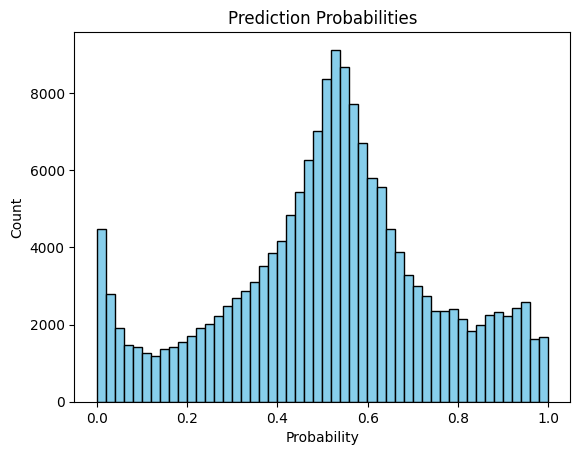

In [15]:
# Run evaluation
evaluate_model(model, test_loader)

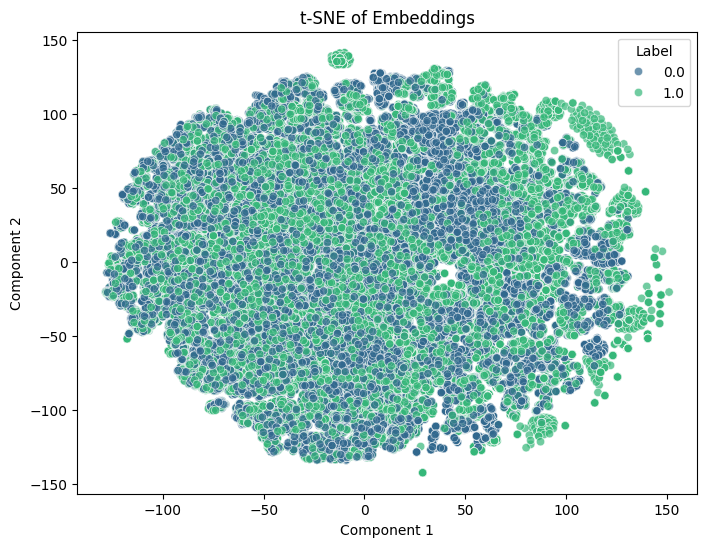

In [17]:
# Visualize embeddings using t-SNE
def extract_embeddings(model, dataloader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for mirna, mrna, label in dataloader:
            mirna, mrna = mirna.to(device), mrna.to(device)
            mirna_embed = model.embedding(mirna).permute(1, 0, 2)
            mrna_embed = model.embedding(mrna).permute(1, 0, 2)
            mirna_encoded = model.transformer(mirna_embed).mean(dim=0).cpu().numpy()
            mrna_encoded = model.transformer(mrna_embed).mean(dim=0).cpu().numpy()
            combined = np.hstack((mirna_encoded, mrna_encoded))
            embeddings.append(combined)
            labels.extend(label.numpy())
    return np.vstack(embeddings), np.array(labels)

# Assuming you already have embeddings and labels
embeddings, labels = extract_embeddings(model, test_loader)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis', alpha=0.7)
plt.title("t-SNE of Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Label')
plt.show()

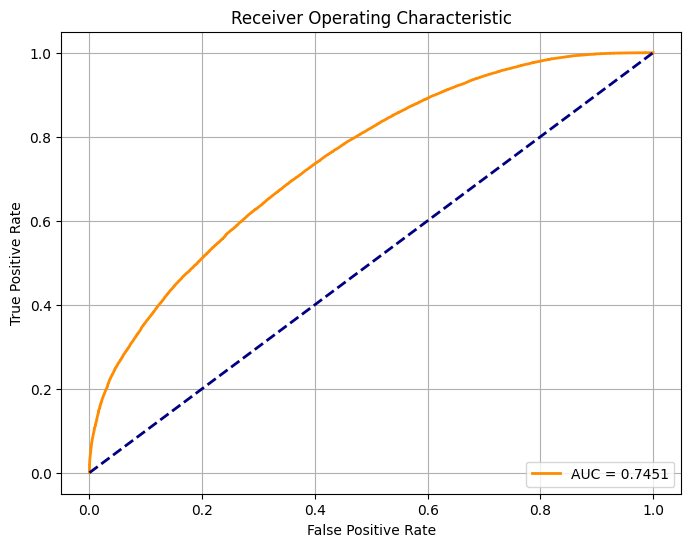

In [20]:
from sklearn.metrics import roc_curve, auc

def plot_auc_roc(trues, probs):
    fpr, tpr, _ = roc_curve(trues, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Run AUC-ROC plotting
def run_auc_roc(model, test_loader):
    model.eval()
    probs, trues = [], []
    with torch.no_grad():
        for mirna, mrna, label in test_loader:
            mirna, mrna = mirna.to(device), mrna.to(device)
            output = model(mirna, mrna)
            probs.extend(output.cpu().numpy())
            trues.extend(label.numpy())
    plot_auc_roc(np.array(trues), np.array(probs))

run_auc_roc(model, test_loader)


In [41]:
class InteractionTransformer_2(nn.Module):
    def __init__(self, embedding_dim=32, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=5, embedding_dim=embedding_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        # Store attention weights
        self.attn_weights = []

    def forward(self, mirna, mrna, return_attention=False):
        print("Forward pass started.")
        mirna_embed = self.embedding(mirna)
        print(f"miRNA embedding shape: {mirna_embed.shape}")
        mrna_embed = self.embedding(mrna)
        print(f"mRNA embedding shape: {mrna_embed.shape}")

        if return_attention:
            attn_weights_mirna = []
            print("Returning attention weights is enabled.")

            # Hook function to capture attention weights
            def hook(module, input, output):
                print(f"Hook activated for module: {module}")
                # Capture attention weights after the forward pass
                try:
                    attn_weights_mirna.append(module.attn.detach().cpu())
                except AttributeError as e:
                    print(f"Error accessing attention output weights: {e}")

            # Register hooks to capture attention weights from each layer
            hooks = []
            for idx, layer in enumerate(self.transformer.layers):
                print(f"Registering hook for layer {idx}")
                hooks.append(layer.self_attn.register_forward_hook(hook))

            # Forward pass through transformer
            mirna_encoded = self.transformer(mirna_embed).mean(dim=1)
            print(f"miRNA encoded shape: {mirna_encoded.shape}")
            mrna_encoded = self.transformer(mrna_embed).mean(dim=1)
            print(f"mRNA encoded shape: {mrna_encoded.shape}")

            # Remove hooks after the forward pass
            for h in hooks:
                h.remove()

            combined = torch.cat((mirna_encoded, mrna_encoded), dim=1)
            out = self.fc(combined).squeeze()
            print(f"Output shape: {out.shape}")

            # Return output and attention weights
            return out, attn_weights_mirna
        else:
            mirna_encoded = self.transformer(mirna_embed).mean(dim=1)
            mrna_encoded = self.transformer(mrna_embed).mean(dim=1)
            combined = torch.cat((mirna_encoded, mrna_encoded), dim=1)
            print(f"Output shape without attention: {combined.shape}")
            return self.fc(combined).squeeze()


In [42]:
def visualize_attention(model, dataloader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for mirna, mrna, _ in dataloader:
            mirna, mrna = mirna.to(device), mrna.to(device)
            print("Calling model with return_attention=True.")
            _, attn_weights = model(mirna, mrna, return_attention=True)

            print(f"Attention weights length: {len(attn_weights)}")
            if len(attn_weights) == 0:
                print("No attention weights captured!")
                continue  # Skip visualization if no attention weights are captured

            for i in range(num_samples):
                # Select the attention weights for a specific sample
                if len(attn_weights) > 0:
                    print(f"Accessing attention map for sample {i}.")
                    attn = attn_weights[0][i].cpu().numpy()  # First layer, ith sample

                    # Plot the attention heatmap
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(attn, cmap="viridis")
                    plt.title(f"miRNA Attention Map (Sample {i})")
                    plt.xlabel("Token")
                    plt.ylabel("Token")
                    plt.show()
            break  # Visualize only for the first batch

# Visualize the attention maps
model = InteractionTransformer_2().to(device)
visualize_attention(model, test_loader)


Streaming output truncated to the last 5000 lines.
  (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
)
Error accessing attention output weights: 'MultiheadAttention' object has no attribute 'attn'
miRNA encoded shape: torch.Size([64, 32])
Hook activated for module: MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
)
Error accessing attention output weights: 'MultiheadAttention' object has no attribute 'attn'
Hook activated for module: MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
)
Error accessing attention output weights: 'MultiheadAttention' object has no attribute 'attn'
mRNA encoded shape: torch.Size([64, 32])
Output shape: torch.Size([64])
Attention weights length: 0
No attention weights captured!
Calling model with return_attention=True.
Forward pass started.
miRNA embedding shape: torch.Size([64, 50, 32])
mRNA embeddi

In [22]:
def get_dot_bracket(seq):
    """Predict dot-bracket notation using ViennaRNA"""
    (structure, mfe) = RNA.fold(seq)
    return structure


In [23]:
def dotbracket_to_graph(seq, structure):
    """Convert RNA sequence and dot-bracket notation to a graph"""
    edge_index = []
    node_features = []

    # Sequential edges
    for i in range(len(seq) - 1):
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])

    # Base pairing edges from dot-bracket
    stack = []
    for i, char in enumerate(structure):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            edge_index.append([i, j])
            edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Node features (one-hot)
    vocab = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'U': [0,0,0,1]}
    for base in seq:
        node_features.append(vocab.get(base.upper(), [0,0,0,0]))
    x = torch.tensor(node_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index)


In [24]:
class HybridModel(nn.Module):
    def __init__(self, transformer, gnn_hidden_dim=32):
        super().__init__()
        self.transformer = transformer
        self.gnn_mirna = GCNConv(4, gnn_hidden_dim)
        self.gnn_mrna = GCNConv(4, gnn_hidden_dim)
        self.output = nn.Sequential(
            nn.Linear(transformer.fc[0].in_features + 2 * gnn_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, mirna, mrna, mirna_graph, mrna_graph):
        transformer_out = self.transformer(mirna, mrna)
        h_mirna = self.gnn_mirna(mirna_graph.x.to(device), mirna_graph.edge_index.to(device)).mean(dim=0)
        h_mrna = self.gnn_mrna(mrna_graph.x.to(device), mrna_graph.edge_index.to(device)).mean(dim=0)
        combined = torch.cat((transformer_out, h_mirna, h_mrna), dim=-1)
        return self.output(combined)


In [30]:
def visualize_attention(model, dataloader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for mirna, mrna, _ in dataloader:
            mirna, mrna = mirna.to(device), mrna.to(device)
            _, attn_weights = model(mirna, mrna, return_attention=True)

            for i in range(num_samples):
                attn = attn_weights[0][i].cpu().numpy()  # First layer, ith sample

                plt.figure(figsize=(6, 5))
                sns.heatmap(attn, cmap="viridis")
                plt.title(f"miRNA Attention Map (Sample {i})")
                plt.xlabel("Token")
                plt.ylabel("Token")
                plt.show()
            break
